# Refine Positive genes

Gaol: postive gesn form tpevios stesp are too broad, a methodd to reifne them is needed.

Idea: 
- find cells in the cycicling prcess
    - use geneset scores to find thme
- use rpevius psotive genes set asa progrma and find if these ghenes are expressed ....

In [44]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import ast
from matplotlib_venn import venn2
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch
os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


# Load scrna datset

In [45]:
data_dir = config["data_paths"]["neftel_data_folder"]

# Load the matrix (Cell by Gene, or Gene by Cell, default is usually gene x cell)
adata = sc.read_mtx(os.path.join(data_dir, 'Exp_data_UMIcounts.mtx')).T # Transpose to get Cell x Gene

# Read feature names (genes) and barcodes (cells)
genes = pd.read_csv(os.path.join(data_dir, 'Genes.txt'), header=None, names=["gene"], sep='\t')
display(genes.head(2))
cells = pd.read_csv(os.path.join(data_dir, 'Cells.csv'), index_col=0)
display(cells.head(2))

# Assign gene names
adata.var_names = genes.gene.astype(str)

# Add cell metadata and ensure obs_names are strings
adata.obs = cells
adata.obs_names = adata.obs.index.astype(str)

print("Data Loaded:")
display(adata.obs)
display(adata.obs.columns)

# check data structure
X = adata.X.toarray()
print("Is data raw of log normalised?")
print("min, max", np.min(adata.X), np.max(adata.X))
print(X[X > 0][:20]) 
print("Has gene ecpression been centered?")
gene_means = np.array(X.mean(axis=0)).ravel()
print("Mean expression per gene (first 10):", gene_means[:10])
print("Overall mean of gene means:", gene_means.mean())

gene
0  FAM138A
1    OR4F5

sample  cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                              
102_1        102  Malignant        3101  20.8435 -12.0361    -0.0434   
102_2        102  Malignant        2366 -12.6327 -18.9353     1.1051   

           g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                
102_1         0.1245      Not cycling        1.1889   Oligo Progenitor   
102_2         0.2308             G1/S        1.4424  Cell Cycle - G1/S   

               mp_assignment  
cell_name                     
102_1       Oligo Progenitor  
102_2      Cell Cycle - G1/S

Data Loaded:


sample  cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                               
102_1         102  Malignant        3101  20.8435 -12.0361    -0.0434   
102_2         102  Malignant        2366 -12.6327 -18.9353     1.1051   
102_4         102  Malignant        1217 -11.9102 -18.0864    -0.1774   
102_5         102  Malignant        2285  20.1392 -11.5944    -0.1211   
102_7         102  Malignant        1725  17.2946 -16.4965    -0.0337   
...           ...        ...         ...      ...      ...        ...   
105_D2_211    105        NaN         451      NaN      NaN        NaN   
105_D2_212    105  Malignant         506      NaN      NaN        NaN   
105_D2_213    105        NaN         680      NaN      NaN        NaN   
105_D2_214    105  Malignant         622      NaN      NaN        NaN   
105_D2_216    105  Malignant         616      NaN      NaN        NaN   

            g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                 
102_1          0.1245      Not cycling        1.1889   Oligo Progenitor   
102_2          0.2308             G1/S        1.4424  Cell Cycle - G1/S   
102_4         -0.0561      Not cycling        1.4340             Stress   
102_5         -0.0473      Not cycling        2.6042   Oligo Progenitor   
102_7         -0.0467      Not cycling        1.5445         NPC Glioma   
...               ...              ...           ...                ...   
105_D2_211        NaN              NaN           NaN                NaN   
105_D2_212        NaN              NaN           NaN                NaN   
105_D2_213        NaN              NaN           NaN                NaN   
105_D2_214        NaN              NaN           NaN                NaN   
105_D2_216        NaN              NaN           NaN                NaN   

                mp_assignment  
cell_name                      
102_1        Oligo Progenitor  
102_2       Cell Cycle - G1/S  
102_4                     NaN  
102_5        Oligo Progenitor  
102_7              NPC Glioma  
...                       ...  
105_D2_211                NaN  
105_D2_212                NaN  
105_D2_213                NaN  
105_D2_214                NaN  
105_D2_216                NaN  

[16201 rows x 11 columns]

Index(['sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score',
       'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top',
       'mp_assignment'],
      dtype='object')

Is data raw of log normalised?
min, max 0.0 9814.0
[2. 1. 2. 2. 3. 1. 1. 1. 1. 1. 4. 1. 1. 2. 2. 3. 4. 4. 1. 4.]
Has gene ecpression been centered?
Mean expression per gene (first 10): [0.0000000e+00 0.0000000e+00 2.6541571e-03 6.1724582e-05 0.0000000e+00
 6.1724582e-05 3.3516449e-01 6.9131535e-03 0.0000000e+00 0.0000000e+00]
Overall mean of gene means: 0.30058536


## Simple Preprocessing

- make genes names unique
- remove cell wiht no cell pahse label
- remove cell wiht to low genes, too mamy genes, to high mt score
- remove geens wiht too low cells
- normalise
- log transfoer
- do NOT scale/center !!!

Are genes unique? True


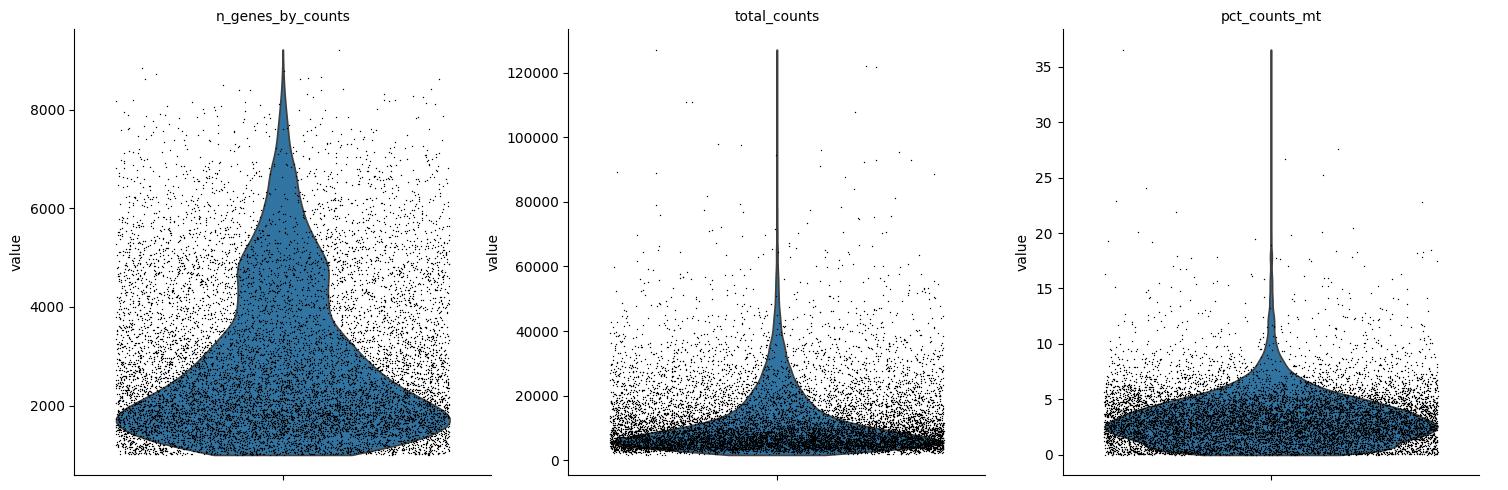

After cell filtering: 10678 cells remain.
After gene filtering: 20740 genes remain.


In [46]:
# ATTENTION: makes genes unqiuie
adata.var_names_make_unique()
print("Are genes unique?", adata.var_names.is_unique)

# ATTETION: remove cells wiht Nonone has label
adata = adata[~adata.obs[["cell_cycle_phase"]].isna().any(axis=1)].copy()

###############

# Identify mitochondrial genes (human: 'MT-', mouse: 'mt-')
adata.var["mt"] = adata.var_names.str.startswith(("MT-", "mt-"))

# Compute per-cell QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)

#
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

# Filter cells ---
min_genes = 200           # drop low-quality cells
max_genes = 6000          # drop likely doublets
max_mito  = 10            # drop cells with >10% mitochondrial reads

adata = adata[
    (adata.obs["n_genes_by_counts"] > min_genes)
    & (adata.obs["n_genes_by_counts"] < max_genes)
    & (adata.obs["pct_counts_mt"] < max_mito),
].copy()

print(f"After cell filtering: {adata.n_obs} cells remain.")

# Filter genes ---
# Keep genes expressed in at least min_cells cells
min_cells = 5
sc.pp.filter_genes(adata, min_cells=min_cells)
print(f"After gene filtering: {adata.n_vars} genes remain.")

# Normalize per cell (to make library sizes comparable)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform (compress the dynamic range)
sc.pp.log1p(adata)

# Store the normalized data for downstream analysis
adata.raw = adata

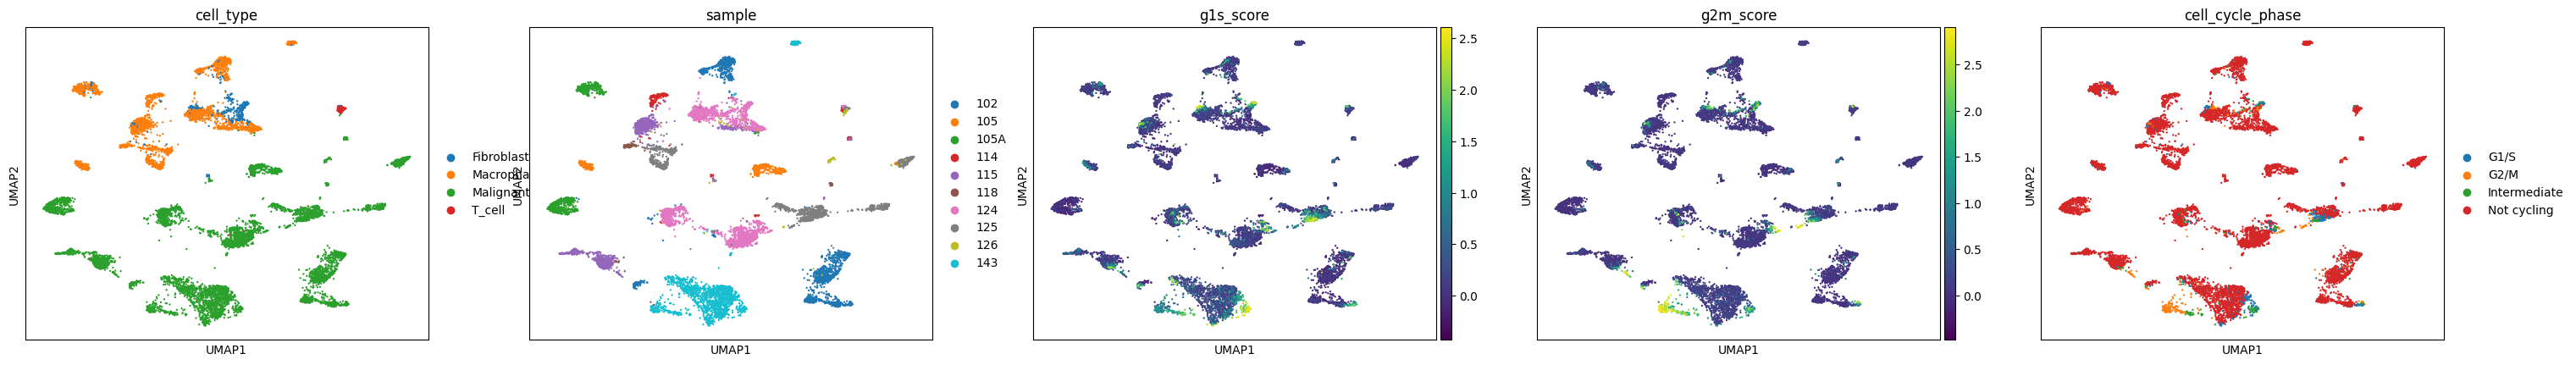

In [47]:
# plot umap
umap_data_array = adata.obs[['umap1', 'umap2']].values
adata.obsm['umap'] = umap_data_array

sc.pl.embedding(adata, basis="umap", color=["cell_type", "sample", "g1s_score", "g2m_score", "cell_cycle_phase"], ncols=5)


In [48]:
# # Get top N highly expressed genes by mean (FOR LATER)
# n_top = 7000

# # Calculate mean expression per gene
# mean_expression_per_gene = adata.X.mean(axis=0)
# if hasattr(mean_expression_per_gene, 'A1'):
#     mean_expression_per_gene = mean_expression_per_gene.A1

# # Get indices of top N genes
# top_n_indices = np.argsort(mean_expression_per_gene)[-n_top:][::-1]  # Descending order
# top_n_genes = adata.var_names[top_n_indices]

# print(f"Top {n_top} highly expressed genes:")
# print(top_n_genes.tolist())

In [49]:
# Identify highly variable genes without altering adata.X
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",   # or "cell_ranger", "seurat", depending on your preference
    n_top_genes=7000,     # number of HVGs to select
    inplace=True,          # store results in adata.var
    subset=False           # don't subset adata.X!
)

# Get a list (or DataFrame) of highly variable genes
top_n_genes = adata.var_names[adata.var["highly_variable"]].tolist()

# Optional: view top 10
print(top_n_genes[:10])

/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


['RP11-54O7.16', 'RP11-54O7.1', 'RP11-54O7.2', 'SAMD11', 'HES4', 'ISG15', 'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SCNN1D']


# Load precalculated putative positive genes

In [50]:
positive_genes_df = pd.read_csv(config["data_paths"]["broad_positive_genes"])

# Sort
positive_genes_df = positive_genes_df.sort_values(by="geneset_count", ascending=False)
display(positive_genes_df)

broad_positive_gene_list = positive_genes_df[positive_genes_df.label == "positive"].gene.to_list()
print("positive genes", len(broad_positive_gene_list))

high_prevalence_broad_positive_gene_list = positive_genes_df[positive_genes_df.label == "positive"].gene[:100].to_list()
print("High prevalence positive genes", len(high_prevalence_broad_positive_gene_list))

gene  geneset_count  is_guaranteed  geneset_count_all     label  \
2      H2AFZ             98           True               1755  positive   
6     MLF1IP             98           True               1755  positive   
1     FAM64A             98           True               1755  positive   
0       CDK1             98           True                894  positive   
4        HN1             98           True               1755  positive   
...      ...            ...            ...                ...       ...   
7278  ZNF782              1          False                 41  ambigous   
7277  ZNF771              1          False                 85  ambigous   
7276  ZNF768              1          False                 97  ambigous   
7275  ZNF766              1          False                 37  ambigous   
7274  ZNF764              1          False                100  ambigous   

      geneset_percent  
2           33.676976  
6           33.676976  
1           33.676976  
0           33.676976  
4           33.676976  
...               ...  
7278         0.343643  
7277         0.343643  
7276         0.343643  
7275         0.343643  
7274         0.343643  

[7294 rows x 6 columns]

positive genes 1148
High prevalence positive genes 100


# Define CC score

As Max between g1s and g2m scores

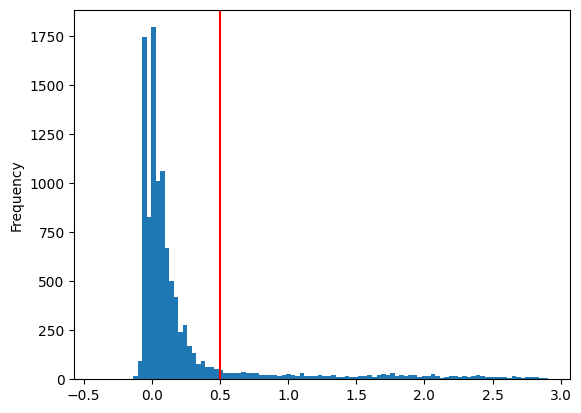

In [51]:
adata.obs["cc_score"] = adata.obs[["g1s_score", "g2m_score"]].max(axis=1)

adata.obs["cc_score"].plot(kind="hist", bins=100)
plt.axvline(0.5, color="red")

# Optional: verify cell phase precimputed labels

Find which cells are in the cell cycle process:
- adata alredy contains this info
- just to be sure recalcuate, how?
    - take genesets related to cell cycle
    - claulte module

In [52]:
# # sho what cell cyel ingo is alredy present
# display(adata.obs.cell_cycle_phase.unique())

# # read VERY spefiic gene set for ccylcing cells
# metaprograms_df = pd.read_excel(config["data_paths"]["metaprograms_3CA"])
# display(metaprograms_df.head(2))

# strict_G2_M_genes = set(metaprograms_df["MP1 Cell Cycle - G2/M"])
# strict_G1_S_genes = set(metaprograms_df["MP2 Cell Cycle - G1/S"])
# strict_cc_genes = strict_G2_M_genes.union(strict_G1_S_genes)
# len(strict_cc_genes)

# # calculate module for each cell
# ctrl_size=10
# sc.tl.score_genes(
#     adata=adata, 
#     gene_list=list(strict_G2_M_genes),
#     ctrl_size=ctrl_size, #ATTENTION: not default
#     gene_pool=None, #all genes
#     n_bins=25,
#     use_raw=False, #use lognorm
#     score_name="G2_M_score"
# )
# sc.tl.score_genes(
#     adata=adata, 
#     gene_list=list(strict_G1_S_genes),
#     ctrl_size=ctrl_size, #ATTENTION: not default
#     gene_pool=None, #all genes
#     n_bins=25,
#     use_raw=False, #use lognorm
#     score_name="G1_S_score"
# )
# sc.tl.score_genes(
#     adata=adata, 
#     gene_list=list(strict_cc_genes),
#     ctrl_size=ctrl_size, #ATTENTION: not default
#     gene_pool=None, #all genes
#     n_bins=25,
#     use_raw=False, #use lognorm
#     score_name="cc_score"
# )

# display(adata.obs)

# # chekc if new scores correlate wiht old ones
# display(adata.obs[["cc_score", "G1_S_score", "G2_M_score", "g1s_score", "g2m_score"]].corr())
# adata.obs[["cc_score"]].plot(kind="hist", bins=100)

# Analyse Cycling Vs Non Cycling

In [53]:
adata_cycling = adata[
    (adata.obs["cell_cycle_phase"] != "Intermediate") &

    # ATTENTION
    (adata.obs["sample"] == "143") & # for single patinet (143 has most cells)

    (adata.obs["cell_type"] == "Malignant") #like in apper https://www.weizmann.ac.il/sites/3CA/study-data/cell-cycle/20099
    ].copy()

# Add label
adata_cycling.obs["phase"] = np.where(
    adata_cycling.obs["cell_cycle_phase"].isin(["G1/S", "G2/M"]), 
    "Cycling", 
    "Not cycling"
)

print("Cycling cells:", adata_cycling.obs["phase"].value_counts())

Cycling cells: phase
Not cycling    1180
Cycling         297
Name: count, dtype: int64


In [54]:
SAMPLE_N = 200

tmp = adata_cycling.obs
tmp = tmp.sort_values("cc_score")

non_cycling_cells_id = set(tmp[(tmp.phase == "Not cycling")].iloc[:SAMPLE_N, :].index)
cycling_cells_id = set(tmp[(tmp.phase == "Cycling")].iloc[-SAMPLE_N:,:].index)

# subsamplòe
adata_cycling_subsampled = adata_cycling[list(non_cycling_cells_id.union(cycling_cells_id))].copy()

# VARIANCE: rmeove gens with zero variance
gene_variances = np.var(adata_cycling_subsampled.X.toarray(), axis=0)
adata_cycling_subsampled = adata_cycling_subsampled[:, gene_variances > 1e-6].copy()

# Sort by phase
adata_cycling_subsampled = adata_cycling_subsampled[adata_cycling_subsampled.obs['phase'].sort_values().index]
adata_cycling_subsampled = adata_cycling_subsampled[adata_cycling_subsampled.obs['cell_cycle_phase'].sort_values().index]

adata_cycling_subsampled

View of AnnData object with n_obs × n_vars = 400 × 16889
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cc_score', 'phase'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'cell_type_colors', 'sample_colors', 'cell_cycle_phase_colors', 'hvg'
    obsm: 'umap'

In [55]:
# Select postive genes in adata
all_genes_in_adata = adata_cycling_subsampled.var_names
top_expressed_genes_in_adata = [g for g in top_n_genes if g in adata_cycling_subsampled.var_names]
all_positive_gene_list_in_adata = [g for g in broad_positive_gene_list if g in adata_cycling_subsampled.var_names]
high_prevalence_broad_positive_gene_list_in_adata = [g for g in high_prevalence_broad_positive_gene_list if g in adata_cycling_subsampled.var_names]
print("Broad postive genes:", len(broad_positive_gene_list))
print("Broad postive genes in adata:", len(all_positive_gene_list_in_adata))
print("High prevalence broad postive genes in adata:", len(high_prevalence_broad_positive_gene_list_in_adata))
print("High prevalence broad postive genes in adata:", len(top_expressed_genes_in_adata))

# Create subsampled df
adata_cycling_subsampled_all = adata_cycling_subsampled[:, all_genes_in_adata].copy()
adata_cycling_subsampled_top = adata_cycling_subsampled[:, top_expressed_genes_in_adata].copy()
adata_cycling_subsampled_all_pos = adata_cycling_subsampled[:, all_positive_gene_list_in_adata].copy()
adata_cycling_subsampled_high_pos = adata_cycling_subsampled[:, high_prevalence_broad_positive_gene_list_in_adata].copy()

Broad postive genes: 1148
Broad postive genes in adata: 992
High prevalence broad postive genes in adata: 97
High prevalence broad postive genes in adata: 4607


###  All malignant cells
- cell-cell correlation matrix (all HQ genes)
- cell-cell correlation (1000 pos genes)
- cell-cell correlation (100 pos genes)
- 
- clustermap correlation (1000 pos genes)
- clustermap correlation (100 pos genes)

cell_name    143_7d_2144  143_7d_1357  143_7d_768  143_7d_1523  143_7d_1291  \
cell_name                                                                     
143_7d_2144     1.000000     0.758166    0.733080     0.755176     0.780578   
143_7d_1357     0.758166     1.000000    0.748691     0.768480     0.799930   
143_7d_768      0.733080     0.748691    1.000000     0.734692     0.765238   
143_7d_1523     0.755176     0.768480    0.734692     1.000000     0.776407   
143_7d_1291     0.780578     0.799930    0.765238     0.776407     1.000000   
...                  ...          ...         ...          ...          ...   
143_7d_672      0.625495     0.627037    0.622354     0.620375     0.641471   
143_7d_1101     0.756244     0.748724    0.735280     0.736430     0.755167   
143_7d_373      0.716687     0.710166    0.749203     0.699711     0.727469   
143_7d_1494     0.683188     0.674718    0.729405     0.645486     0.679588   
143_7d_1579     0.755402     0.733263    0.733360     0.733977     0.752033   

cell_name    143_7d_2269  143_7d_511  143_7d_1342  143_7d_1668  143_7d_807  \
cell_name                                                                    
143_7d_2144     0.754011    0.771418     0.732453     0.765931    0.702606   
143_7d_1357     0.779420    0.756843     0.723264     0.790492    0.723628   
143_7d_768      0.750959    0.768546     0.704115     0.772110    0.783186   
143_7d_1523     0.765091    0.747294     0.723923     0.765807    0.708773   
143_7d_1291     0.790562    0.769072     0.750563     0.796713    0.738815   
...                  ...         ...          ...          ...         ...   
143_7d_672      0.662688    0.627128     0.630836     0.624616    0.607588   
143_7d_1101     0.756087    0.744666     0.715544     0.751097    0.716552   
143_7d_373      0.730108    0.738012     0.691834     0.727278    0.741589   
143_7d_1494     0.676791    0.694262     0.639930     0.690898    0.729391   
143_7d_1579     0.746627    0.752870     0.716131     0.746840    0.716486   

cell_name    ...  143_7d_1524  143_7d_469  143_7d_963  143_7d_2141  \
cell_name    ...                                                     
143_7d_2144  ...     0.663058    0.720040    0.721963     0.722721   
143_7d_1357  ...     0.641481    0.700376    0.712802     0.708719   
143_7d_768   ...     0.704212    0.682424    0.697158     0.743066   
143_7d_1523  ...     0.631012    0.694273    0.705441     0.700656   
143_7d_1291  ...     0.655500    0.713610    0.729745     0.724491   
...          ...          ...         ...         ...          ...   
143_7d_672   ...     0.555272    0.619373    0.632789     0.642240   
143_7d_1101  ...     0.679510    0.728301    0.740475     0.738142   
143_7d_373   ...     0.685637    0.683051    0.709703     0.767694   
143_7d_1494  ...     0.687808    0.644375    0.668739     0.714103   
143_7d_1579  ...     0.673027    0.717259    0.746025     0.737018   

cell_name    143_7d_487  143_7d_672  143_7d_1101  143_7d_373  143_7d_1494  \
cell_name                                                                   
143_7d_2144    0.729674    0.625495     0.756244    0.716687     0.683188   
143_7d_1357    0.715509    0.627037     0.748724    0.710166     0.674718   
143_7d_768     0.690333    0.622354     0.735280    0.749203     0.729405   
143_7d_1523    0.716842    0.620375     0.736430    0.699711     0.645486   
143_7d_1291    0.729000    0.641471     0.755167    0.727469     0.679588   
...                 ...         ...          ...         ...          ...   
143_7d_672     0.632792    1.000000     0.636255    0.647693     0.587855   
143_7d_1101    0.731977    0.636255     1.000000    0.741129     0.711691   
143_7d_373     0.700539    0.647693     0.741129    1.000000     0.712226   
143_7d_1494    0.651468    0.587855     0.711691    0.712226     1.000000   
143_7d_1579    0.735176    0.643616     0.764888    0.744072     0.686437   

cell_name    143_7d_1579  
cell_name        

cell_name    143_7d_2144  143_7d_1357  143_7d_768  143_7d_1523  143_7d_1291  \
cell_name                                                                     
143_7d_2144     1.000000     0.814601    0.754232     0.834112     0.845625   
143_7d_1357     0.814601     1.000000    0.781850     0.844450     0.872799   
143_7d_768      0.754232     0.781850    1.000000     0.769386     0.789272   
143_7d_1523     0.834112     0.844450    0.769386     1.000000     0.851957   
143_7d_1291     0.845625     0.872799    0.789272     0.851957     1.000000   
...                  ...          ...         ...          ...          ...   
143_7d_672      0.742842     0.709361    0.701215     0.720259     0.724692   
143_7d_1101     0.825857     0.803241    0.765900     0.801440     0.804211   
143_7d_373      0.757407     0.732364    0.795227     0.750715     0.755692   
143_7d_1494     0.634694     0.611528    0.710561     0.588352     0.604942   
143_7d_1579     0.821386     0.776914    0.769025     0.798635     0.807051   

cell_name    143_7d_2269  143_7d_511  143_7d_1342  143_7d_1668  143_7d_807  \
cell_name                                                                    
143_7d_2144     0.836243    0.841364     0.822741     0.829828    0.699501   
143_7d_1357     0.848421    0.809397     0.798736     0.859308    0.719273   
143_7d_768      0.779639    0.831454     0.741864     0.807325    0.811700   
143_7d_1523     0.848125    0.827725     0.817715     0.838286    0.707556   
143_7d_1291     0.856390    0.825451     0.829024     0.854909    0.730582   
...                  ...         ...          ...          ...         ...   
143_7d_672      0.768021    0.728334     0.736896     0.712022    0.646638   
143_7d_1101     0.815976    0.811975     0.786198     0.800712    0.720307   
143_7d_373      0.771407    0.807802     0.747866     0.757207    0.772106   
143_7d_1494     0.618890    0.660116     0.593660     0.632178    0.697837   
143_7d_1579     0.808755    0.819522     0.794152     0.796784    0.724973   

cell_name    ...  143_7d_1524  143_7d_469  143_7d_963  143_7d_2141  \
cell_name    ...                                                     
143_7d_2144  ...     0.676415    0.804573    0.814939     0.768602   
143_7d_1357  ...     0.660610    0.781968    0.789462     0.733854   
143_7d_768   ...     0.774247    0.724594    0.746264     0.786132   
143_7d_1523  ...     0.656848    0.783282    0.794961     0.734886   
143_7d_1291  ...     0.671221    0.793544    0.805264     0.741540   
...          ...          ...         ...         ...          ...   
143_7d_672   ...     0.634249    0.742893    0.753665     0.731352   
143_7d_1101  ...     0.717989    0.825785    0.816186     0.781525   
143_7d_373   ...     0.760457    0.741670    0.763091     0.838628   
143_7d_1494  ...     0.694848    0.606018    0.631616     0.689507   
143_7d_1579  ...     0.715634    0.806230    0.831319     0.781060   

cell_name    143_7d_487  143_7d_672  143_7d_1101  143_7d_373  143_7d_1494  \
cell_name                                                                   
143_7d_2144    0.802134    0.742842     0.825857    0.757407     0.634694   
143_7d_1357    0.766319    0.709361     0.803241    0.732364     0.611528   
143_7d_768     0.696683    0.701215     0.765900    0.795227     0.710561   
143_7d_1523    0.792861    0.720259     0.801440    0.750715     0.588352   
143_7d_1291    0.786727    0.724692     0.804211    0.755692     0.604942   
...                 ...         ...          ...         ...          ...   
143_7d_672     0.741014    1.000000     0.726705    0.736236     0.574433   
143_7d_1101    0.786203    0.726705     1.000000    0.784241     0.669510   
143_7d_373     0.724992    0.736236     0.784241    1.000000     0.686634   
143_7d_1494    0.584040    0.574433     0.669510    0.686634     1.000000   
143_7d_1579    0.804981    0.740286     0.822960    0.789866     0.633131   

cell_name    143_7d_1579  
cell_name        

cell_name    143_7d_2144  143_7d_1357  143_7d_768  143_7d_1523  143_7d_1291  \
cell_name                                                                     
143_7d_2144     1.000000     0.675212    0.677201     0.723612     0.745268   
143_7d_1357     0.675212     1.000000    0.715961     0.757250     0.797662   
143_7d_768      0.677201     0.715961    1.000000     0.707051     0.760341   
143_7d_1523     0.723612     0.757250    0.707051     1.000000     0.771853   
143_7d_1291     0.745268     0.797662    0.760341     0.771853     1.000000   
...                  ...          ...         ...          ...          ...   
143_7d_672      0.574961     0.504347    0.480951     0.516421     0.550558   
143_7d_1101     0.738571     0.642496    0.625525     0.663185     0.681663   
143_7d_373      0.659986     0.590199    0.642477     0.603304     0.623323   
143_7d_1494     0.656670     0.553120    0.609347     0.565614     0.581863   
143_7d_1579     0.743595     0.640159    0.616652     0.656948     0.680930   

cell_name    143_7d_2269  143_7d_511  143_7d_1342  143_7d_1668  143_7d_807  \
cell_name                                                                    
143_7d_2144     0.735949    0.746992     0.732324     0.685162    0.660545   
143_7d_1357     0.732883    0.693288     0.655582     0.784302    0.643753   
143_7d_768      0.700289    0.715800     0.649164     0.740678    0.695776   
143_7d_1523     0.746441    0.713128     0.679405     0.720083    0.644369   
143_7d_1291     0.770453    0.734839     0.689404     0.780874    0.677830   
...                  ...         ...          ...          ...         ...   
143_7d_672      0.590213    0.554112     0.558604     0.500981    0.540159   
143_7d_1101     0.707348    0.697965     0.716173     0.635212    0.636389   
143_7d_373      0.663502    0.664502     0.625945     0.607533    0.688340   
143_7d_1494     0.611449    0.673044     0.596264     0.570185    0.683321   
143_7d_1579     0.710893    0.697020     0.687172     0.628631    0.640864   

cell_name    ...  143_7d_1524  143_7d_469  143_7d_963  143_7d_2141  \
cell_name    ...                                                     
143_7d_2144  ...     0.688180    0.707664    0.713663     0.685540   
143_7d_1357  ...     0.577839    0.581319    0.636533     0.590244   
143_7d_768   ...     0.618136    0.575534    0.602766     0.604481   
143_7d_1523  ...     0.590729    0.620022    0.641090     0.585792   
143_7d_1291  ...     0.590824    0.628393    0.677195     0.633938   
...          ...          ...         ...         ...          ...   
143_7d_672   ...     0.582654    0.588624    0.601606     0.625292   
143_7d_1101  ...     0.727561    0.738564    0.766783     0.707548   
143_7d_373   ...     0.703190    0.645306    0.703534     0.747010   
143_7d_1494  ...     0.716102    0.644144    0.691936     0.724049   
143_7d_1579  ...     0.705296    0.717012    0.771169     0.710266   

cell_name    143_7d_487  143_7d_672  143_7d_1101  143_7d_373  143_7d_1494  \
cell_name                                                                   
143_7d_2144    0.704543    0.574961     0.738571    0.659986     0.656670   
143_7d_1357    0.627440    0.504347     0.642496    0.590199     0.553120   
143_7d_768     0.585386    0.480951     0.625525    0.642477     0.609347   
143_7d_1523    0.644194    0.516421     0.663185    0.603304     0.565614   
143_7d_1291    0.640294    0.550558     0.681663    0.623323     0.581863   
...                 ...         ...          ...         ...          ...   
143_7d_672     0.611221    1.000000     0.623143    0.586182     0.572075   
143_7d_1101    0.757410    0.623143     1.000000    0.719724     0.717591   
143_7d_373     0.703167    0.586182     0.719724    1.000000     0.743326   
143_7d_1494    0.687846    0.572075     0.717591    0.743326     1.000000   
143_7d_1579    0.755661    0.606104     0.790426    0.693866     0.692193   

cell_name    143_7d_1579  
cell_name        

cell_name    143_7d_2144  143_7d_1357  143_7d_768  143_7d_1523  143_7d_1291  \
cell_name                                                                     
143_7d_2144     1.000000     0.566626    0.553830     0.673241     0.734485   
143_7d_1357     0.566626     1.000000    0.664163     0.787485     0.810870   
143_7d_768      0.553830     0.664163    1.000000     0.644176     0.729093   
143_7d_1523     0.673241     0.787485    0.644176     1.000000     0.779498   
143_7d_1291     0.734485     0.810870    0.729093     0.779498     1.000000   
...                  ...          ...         ...          ...          ...   
143_7d_672      0.330087     0.322174    0.286914     0.327952     0.316614   
143_7d_1101     0.596350     0.635890    0.469937     0.630409     0.619742   
143_7d_373      0.404980     0.406148    0.380574     0.428039     0.421149   
143_7d_1494     0.538671     0.522276    0.494617     0.531875     0.564748   
143_7d_1579     0.595954     0.501301    0.368505     0.515876     0.572531   

cell_name    143_7d_2269  143_7d_511  143_7d_1342  143_7d_1668  143_7d_807  \
cell_name                                                                    
143_7d_2144     0.730019    0.635834     0.606355     0.517038    0.669693   
143_7d_1357     0.731129    0.639616     0.521956     0.812720    0.613755   
143_7d_768      0.598136    0.641927     0.479983     0.714651    0.612973   
143_7d_1523     0.757405    0.695447     0.538826     0.696588    0.652961   
143_7d_1291     0.815513    0.671891     0.565164     0.750021    0.718689   
...                  ...         ...          ...          ...         ...   
143_7d_672      0.441553    0.349010     0.410091     0.367556    0.429776   
143_7d_1101     0.751267    0.589122     0.660176     0.595832    0.637750   
143_7d_373      0.550812    0.438655     0.376755     0.479920    0.505001   
143_7d_1494     0.590115    0.671020     0.556662     0.506194    0.611895   
143_7d_1579     0.656191    0.516526     0.621277     0.433187    0.658794   

cell_name    ...  143_7d_1524  143_7d_469  143_7d_963  143_7d_2141  \
cell_name    ...                                                     
143_7d_2144  ...     0.570488    0.529735    0.495317     0.604139   
143_7d_1357  ...     0.476323    0.506005    0.553643     0.514816   
143_7d_768   ...     0.527463    0.423228    0.355688     0.441146   
143_7d_1523  ...     0.499814    0.525223    0.556823     0.527732   
143_7d_1291  ...     0.505663    0.510189    0.530649     0.571085   
...          ...          ...         ...         ...          ...   
143_7d_672   ...     0.577031    0.501090    0.422802     0.573353   
143_7d_1101  ...     0.660255    0.851759    0.735490     0.736376   
143_7d_373   ...     0.655168    0.560741    0.593050     0.655420   
143_7d_1494  ...     0.648932    0.563382    0.598374     0.604147   
143_7d_1579  ...     0.653106    0.780800    0.742062     0.737497   

cell_name    143_7d_487  143_7d_672  143_7d_1101  143_7d_373  143_7d_1494  \
cell_name                                                                   
143_7d_2144    0.498235    0.330087     0.596350    0.404980     0.538671   
143_7d_1357    0.572321    0.322174     0.635890    0.406148     0.522276   
143_7d_768     0.327438    0.286914     0.469937    0.380574     0.494617   
143_7d_1523    0.563742    0.327952     0.630409    0.428039     0.531875   
143_7d_1291    0.581078    0.316614     0.619742    0.421149     0.564748   
...                 ...         ...          ...         ...          ...   
143_7d_672     0.524987    1.000000     0.602022    0.826866     0.455654   
143_7d_1101    0.798235    0.602022     1.000000    0.660711     0.640292   
143_7d_373     0.587175    0.826866     0.660711    1.000000     0.599517   
143_7d_1494    0.618660    0.455654     0.640292    0.599517     1.000000   
143_7d_1579    0.735520    0.429216     0.823292    0.490580     0.592090   

cell_name    143_7d_1579  
cell_name        

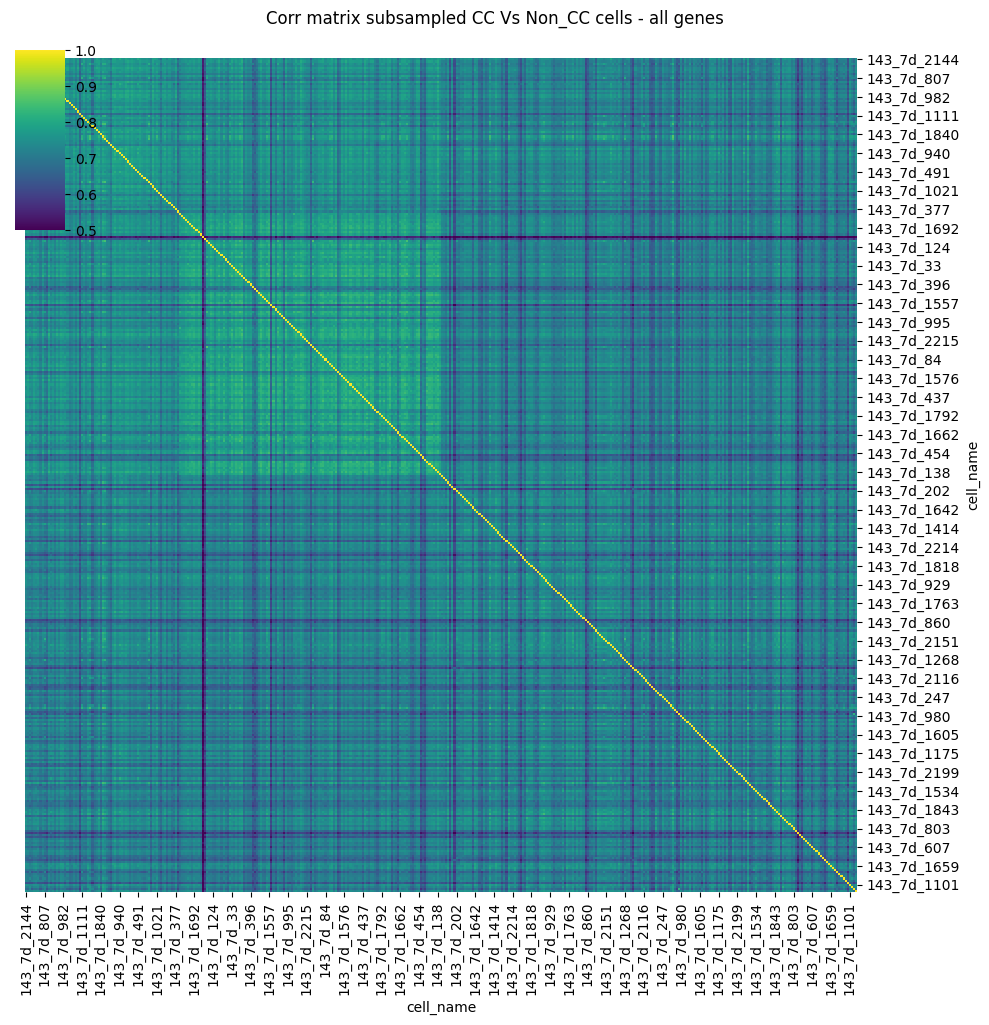

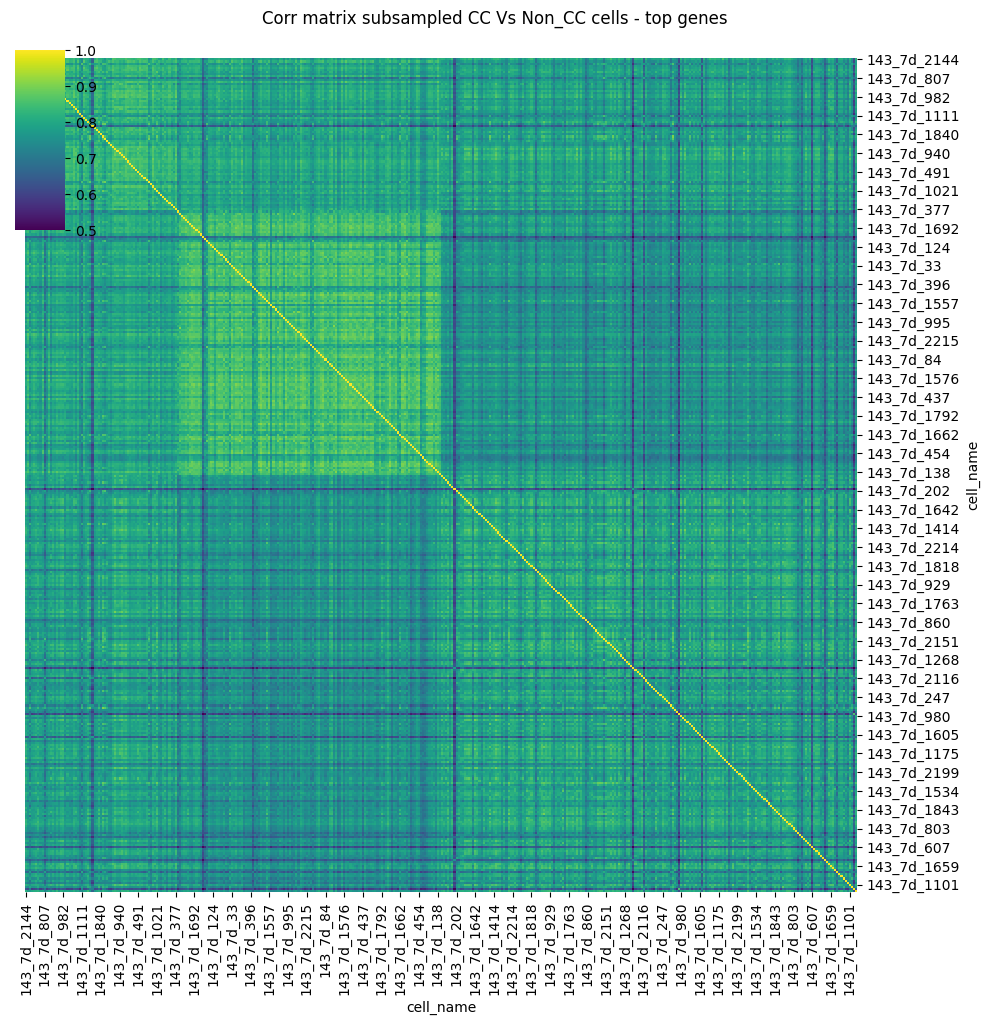

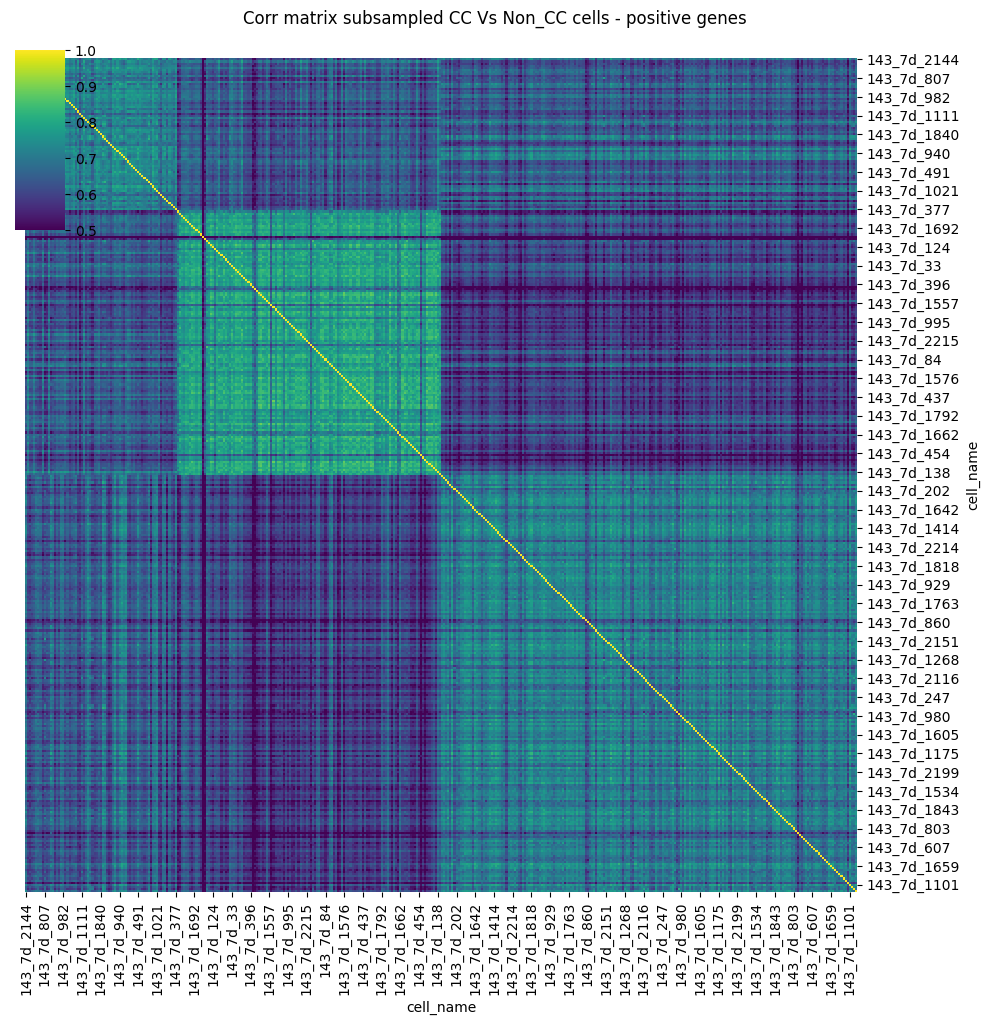

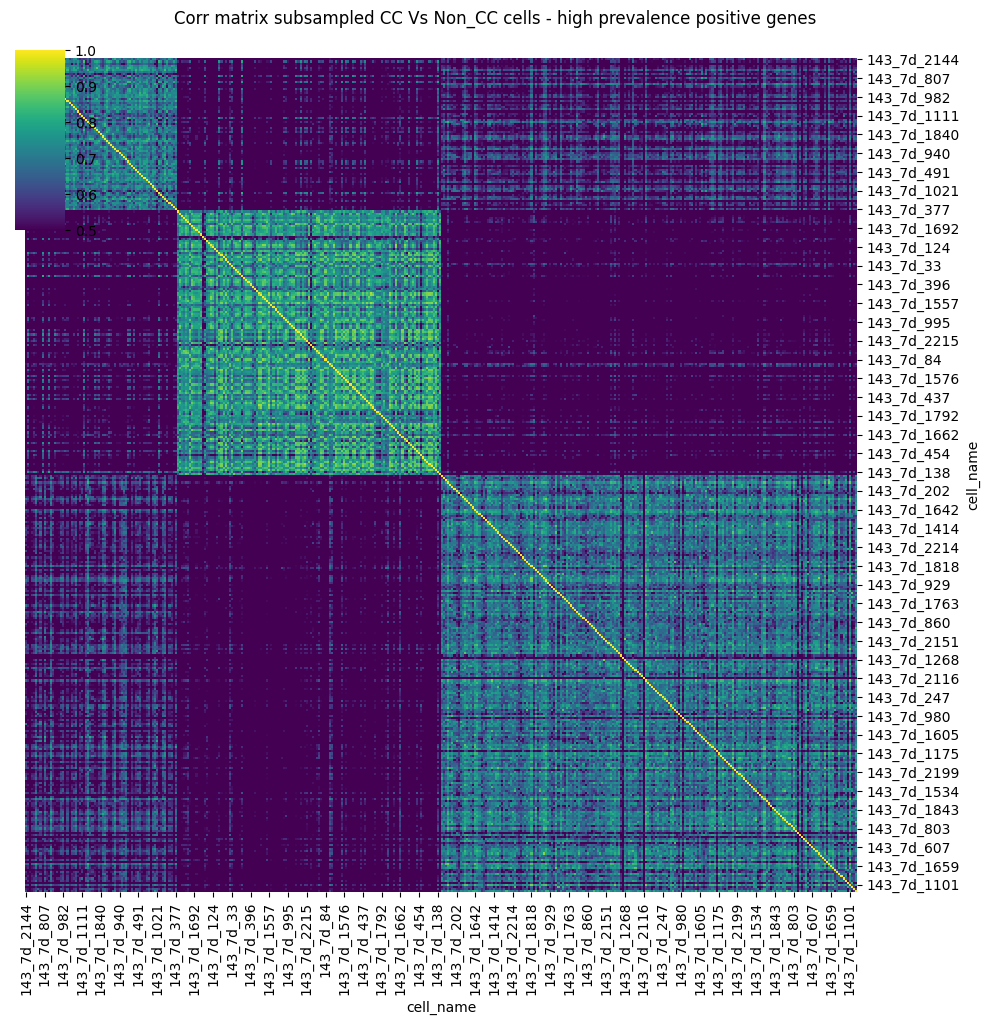

In [56]:
# all genes
df_all = pd.DataFrame(adata_cycling_subsampled_all.X.toarray(), # all genes
                  index=adata_cycling_subsampled_all.obs_names, 
                  columns=adata_cycling_subsampled_all.var_names)
corr_cells_df_all = df_all.T.corr() #to have cells has cols
display(corr_cells_df_all)

# all genes
df_top = pd.DataFrame(adata_cycling_subsampled_top.X.toarray(), # all genes
                  index=adata_cycling_subsampled_top.obs_names, 
                  columns=adata_cycling_subsampled_top.var_names)
corr_cells_df_top = df_top.T.corr() #to have cells has cols
display(corr_cells_df_top)

# only broad positive genes
df_all_pos = pd.DataFrame(adata_cycling_subsampled_all_pos.X.toarray(), # all genes
                  index=adata_cycling_subsampled_all_pos.obs_names, 
                  columns=adata_cycling_subsampled_all_pos.var_names)
corr_cells_df_all_pos = df_all_pos.T.corr() #to have cells has cols
display(corr_cells_df_all_pos)

# only high prevalencebroad positive genes
df_high_pos = pd.DataFrame(adata_cycling_subsampled_high_pos.X.toarray(), # all genes
                  index=adata_cycling_subsampled_high_pos.obs_names, 
                  columns=adata_cycling_subsampled_high_pos.var_names)
corr_cells_high_pos = df_high_pos.T.corr() #to have cells has cols
display(corr_cells_high_pos)

def plot_corr_matrix(corr_cells_df, title):
    g = sns.clustermap(
        corr_cells_df,  
        figsize=(10, 10),
        cmap="viridis",

        # Just corr matric no need to clsuter
        col_cluster=False, 
        row_cluster=False,

        dendrogram_ratio=0.01,  # Reduces dendrogram size (default is 0.2)

        #method="average", # method to do clustering
        #metric="correlation", # metric to aggregate in hierarhcical clustering

        vmin = 0.5, vmax = 1, #for corr
        #standard_scale=0,#z_score=1 # for corr no need to scale
    )
    g.fig.suptitle(title, y=1.02)  # y>1 places it above the plot
    plt.show()

plot_corr_matrix(corr_cells_df_all, title="Corr matrix subsampled CC Vs Non_CC cells - all genes")
plot_corr_matrix(corr_cells_df_top, title="Corr matrix subsampled CC Vs Non_CC cells - top genes")
plot_corr_matrix(corr_cells_df_all_pos, title="Corr matrix subsampled CC Vs Non_CC cells - positive genes")
plot_corr_matrix(corr_cells_high_pos, title="Corr matrix subsampled CC Vs Non_CC cells - high prevalence positive genes")

In [ ]:
# def plot_clustermap_ordered_annotations(adata, title, cycling_col="phase", 
#                                        cell_type_col="cell_cycle_phase",
#                                        use_zscore=True,
#                                        select_range=None):  # NEW: tuple (start_idx, end_idx)
#     """
#     Plot clustermap with optional gene selection range visualization.
    
#     Parameters:
#     -----------
#     select_range : tuple of (int, int) or None
#         If provided, draws horizontal lines at these row indices to show selection range.
#         Example: (0, 50) to select first 50 genes in clustered order
    
#     Returns:
#     --------
#     dict with keys:
#         - 'clustermap': the seaborn ClusterGrid object
#         - 'gene_order': list of genes in clustered order
#         - 'selected_genes': list of genes in the selection range (if select_range provided)
#     """
    
#     # Extract data
#     data = adata.to_df().T  # Genes x Cells
    
#     # If using z-score
#     if use_zscore:
#         scaler = StandardScaler()
#         data_scaled = scaler.fit_transform(data.T).T  # Scale genes
        
#         data_plot = pd.DataFrame(
#             data_scaled,
#             index=data.index,
#             columns=data.columns
#         )
        
#         # Clip extreme values
#         data_plot = np.clip(data_plot, -3, 3)
        
#         cmap = 'RdBu_r'
#         center = 0
#         vmin, vmax = -3, 3
#     else:
#         data_plot = data
#         cmap = 'viridis'
#         center = None
        
#         # Use percentile-based limits
#         vmin = np.percentile(data.values, 5)
#         vmax = np.percentile(data.values, 95)
    
#     # Define color mappings
#     phase_color_map = {
#         'Cycling': 'yellow',
#         'Not cycling': 'blue', 
#     }
    
#     cell_type_color_map = {
#         'G1/S': 'red',
#         'G2/M': 'green',
#         'Intermediate': 'grey',
#         'Not cycling': 'blue', 
#     }
    
#     # Create annotations
#     phase_colors = adata.obs[cycling_col].map(phase_color_map)
#     cell_type_colors = adata.obs[cell_type_col].map(cell_type_color_map)
    
#     col_colors_df = pd.DataFrame({
#         'Phase': phase_colors,
#         'Cell Type': cell_type_colors,
#     })
    
#     # Create clustermap
#     g = sns.clustermap(
#         data_plot,
#         cmap=cmap,
#         center=center,
#         vmin=vmin,
#         vmax=vmax,
#         figsize=(10,15),
        
#         # Clustering
#         col_cluster=False,
#         row_cluster=True,
#         # method='ward',
#         # metric='euclidean',
#         method='average',
#         metric='correlation',

#         # Annotations
#         col_colors=col_colors_df,
        
#         # Appearance
#         dendrogram_ratio=(0.15, 0.05),
#         cbar_pos=(0.02, 0.8, 0.03, 0.15),
#         yticklabels=True,
#         xticklabels=False,
#     )
    
#     # Add legends
#     phase_handles = [Patch(facecolor=color, label=label) 
#                      for label, color in phase_color_map.items()]
#     legend1 = g.fig.legend(phase_handles, phase_color_map.keys(), 
#                           title='Phase',
#                           bbox_to_anchor=(1.02, 0.9), 
#                           loc='upper left',
#                           frameon=True)
    
#     cell_type_handles = [Patch(facecolor=color, label=label) 
#                         for label, color in cell_type_color_map.items()]
#     legend2 = g.fig.legend(cell_type_handles, cell_type_color_map.keys(),
#                           title='Cell Type',
#                           bbox_to_anchor=(1.02, 0.6),
#                           loc='upper left',
#                           frameon=True)
    
#     g.fig.add_artist(legend1)
#     g.fig.suptitle(title, y=1.02)
    
#     # Extract gene order after clustering
#     reordered_genes = g.dendrogram_row.reordered_ind
#     gene_order = adata.var_names[reordered_genes].tolist()
    
#     # NEW: Add horizontal lines to show selection range
#     selected_genes = None
#     if select_range is not None:
#         start_idx, end_idx = select_range
        
#         # Get the heatmap axes
#         heatmap_ax = g.ax_heatmap
        
#         # Draw horizontal lines
#         # Note: In the heatmap, y-axis goes from 0 (bottom) to n_genes (top)
#         # But visually, index 0 is at the TOP of the display
#         n_genes = len(gene_order)
        
#         # Convert indices: visual top is index 0, which is y-position n_genes
#         # Visual position = n_genes - index
#         y_start = n_genes - start_idx
#         y_end = n_genes - end_idx
        
#         # Draw lines
#         heatmap_ax.axhline(y=y_start, color='lime', linewidth=3, linestyle='--', alpha=0.8, label='Selection start')
#         heatmap_ax.axhline(y=y_end, color='lime', linewidth=3, linestyle='--', alpha=0.8, label='Selection end')
        
#         # Add a subtle background highlight
#         heatmap_ax.axhspan(y_end, y_start, alpha=0.1, color='lime', zorder=-1)
        
#         # Extract selected genes
#         selected_genes = gene_order[start_idx:end_idx]
        
#         # Add text annotation
#         mid_y = (y_start + y_end) / 2
#         heatmap_ax.text(-2, mid_y, f'Selected\n{len(selected_genes)} genes', 
#                        fontsize=12, color='lime', fontweight='bold',
#                        ha='right', va='center',
#                        bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
#     # Return results
#     return {
#         'clustermap': g,
#         'gene_order': gene_order,
#         'selected_genes': selected_genes
#     }

In [58]:
def plot_clustermap_ordered_annotations(adata, title, cycling_col="phase", 
                                       cell_type_col="cell_cycle_phase",
                                       use_zscore=True,
                                       select_range=None,  # tuple (start_idx, end_idx)
                                       show_genes=None):    # list of gene names to show on y-axis
    """
    Plot clustermap with optional gene selection range visualization.
    
    Parameters:
    -----------
    select_range : tuple of (int, int) or None
        If provided, draws horizontal lines at these row indices to show selection range.
        Indices refer to positions in the CLUSTERED order (0 = top of heatmap).
        Example: (0, 50) to select first 50 genes from top of clustered heatmap
    show_genes : list of str or None
        If provided, only these gene names will be shown on the y-axis labels.
        All other genes will have empty labels.
    
    Returns:
    --------
    dict with keys:
        - 'clustermap': the seaborn ClusterGrid object
        - 'gene_order': list of genes in clustered order (top to bottom)
        - 'selected_genes': list of genes in the selection range (if select_range provided)
    """
    
    # Extract data
    data = adata.to_df().T  # Genes x Cells
    
    # If using z-score
    if use_zscore:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data.T).T  # Scale genes
        
        data_plot = pd.DataFrame(
            data_scaled,
            index=data.index,
            columns=data.columns
        )
        
        # Clip extreme values
        data_plot = np.clip(data_plot, -3, 3)
        
        cmap = 'RdBu_r'
        center = 0
        vmin, vmax = -3, 3
    else:
        data_plot = data
        cmap = 'viridis'
        center = None
        
        # Use percentile-based limits
        vmin = np.percentile(data.values, 5)
        vmax = np.percentile(data.values, 95)
    
    # Define color mappings
    phase_color_map = {
        'Cycling': 'yellow',
        'Not cycling': 'blue', 
    }
    
    cell_type_color_map = {
        'G1/S': 'red',
        'G2/M': 'green',
        'Intermediate': 'grey',
        'Not cycling': 'blue', 
    }
    
    # Create annotations
    phase_colors = adata.obs[cycling_col].map(phase_color_map)
    cell_type_colors = adata.obs[cell_type_col].map(cell_type_color_map)
    
    col_colors_df = pd.DataFrame({
        'Phase': phase_colors,
        'Cell Type': cell_type_colors,
    })
    
    # Create clustermap
    g = sns.clustermap(
        data_plot,
        cmap=cmap,
        center=center,
        vmin=vmin,
        vmax=vmax,
        figsize=(10,15),
        
        # Clustering
        col_cluster=False,
        row_cluster=True,
        # method='ward',
        # metric='euclidean',
        method='average',
        metric='correlation',

        # Annotations
        col_colors=col_colors_df,
        
        # Appearance
        dendrogram_ratio=(0.15, 0.05),
        cbar_pos=(0.02, 0.8, 0.03, 0.15),
        yticklabels=True,
        xticklabels=False,
    )
    
    # Filter y-axis labels to show only specified genes
    if show_genes is not None:
        # Get current y-axis
        ax = g.ax_heatmap
        
        # Get current tick labels (these are in clustered order)
        current_labels = [label.get_text() for label in ax.get_yticklabels()]
        
        # Create new labels: keep gene name if in show_genes list, otherwise empty string
        show_genes_set = set(show_genes)
        new_labels = [label if label in show_genes_set else '' for label in current_labels]
        
        # Set the filtered labels
        ax.set_yticklabels(new_labels)
    
    # Add legends
    phase_handles = [Patch(facecolor=color, label=label) 
                     for label, color in phase_color_map.items()]
    legend1 = g.fig.legend(phase_handles, phase_color_map.keys(), 
                          title='Phase',
                          bbox_to_anchor=(1.02, 0.9), 
                          loc='upper left',
                          frameon=True)
    
    cell_type_handles = [Patch(facecolor=color, label=label) 
                        for label, color in cell_type_color_map.items()]
    legend2 = g.fig.legend(cell_type_handles, cell_type_color_map.keys(),
                          title='Cell Type',
                          bbox_to_anchor=(1.02, 0.6),
                          loc='upper left',
                          frameon=True)
    
    g.fig.add_artist(legend1)
    g.fig.suptitle(title, y=1.02)
    
    # Extract gene order after clustering
    reordered_genes = g.dendrogram_row.reordered_ind
    gene_order = adata.var_names[reordered_genes].tolist()
    
    # Add horizontal lines to show selection range
    selected_genes = None
    if select_range is not None:
        start_idx, end_idx = select_range
        
        # Get the heatmap axes
        heatmap_ax = g.ax_heatmap
        
        # COORDINATE SYSTEM EXPLANATION:
        # - gene_order[0] is the gene at the TOP of the visual heatmap
        # - gene_order[-1] is the gene at the BOTTOM of the visual heatmap
        # - In matplotlib imshow/heatmap coordinates:
        #   - y=0 is at the TOP
        #   - y=n_genes is at the BOTTOM
        # - axhline draws at a specific y coordinate
        
        n_genes = len(gene_order)
        
        # Direct mapping: index in gene_order = y-coordinate
        # start_idx=0 (top gene) -> y=0 (top of plot)
        # start_idx=50 -> y=50
        y_start = start_idx
        y_end = end_idx
        
        # Draw lines (note: need to add 0.5 to align with row boundaries)
        heatmap_ax.axhline(y=y_start - 0.5, color='lime', linewidth=3, linestyle='--', 
                          alpha=0.8, label='Selection start')
        heatmap_ax.axhline(y=y_end - 0.5, color='lime', linewidth=3, linestyle='--', 
                          alpha=0.8, label='Selection end')
        
        # Add a subtle background highlight
        heatmap_ax.axhspan(y_start - 0.5, y_end - 0.5, alpha=0.1, color='lime', zorder=-1)
        
        # Extract selected genes
        selected_genes = gene_order[start_idx:end_idx]
        
        # Add text annotation
        mid_y = (y_start + y_end - 1) / 2
        heatmap_ax.text(-2, mid_y, f'Selected\n{len(selected_genes)} genes', 
                       fontsize=12, color='lime', fontweight='bold',
                       ha='right', va='center',
                       bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    # Return results
    return {
        'clustermap': g,
        'gene_order': gene_order,
        'selected_genes': selected_genes
    }

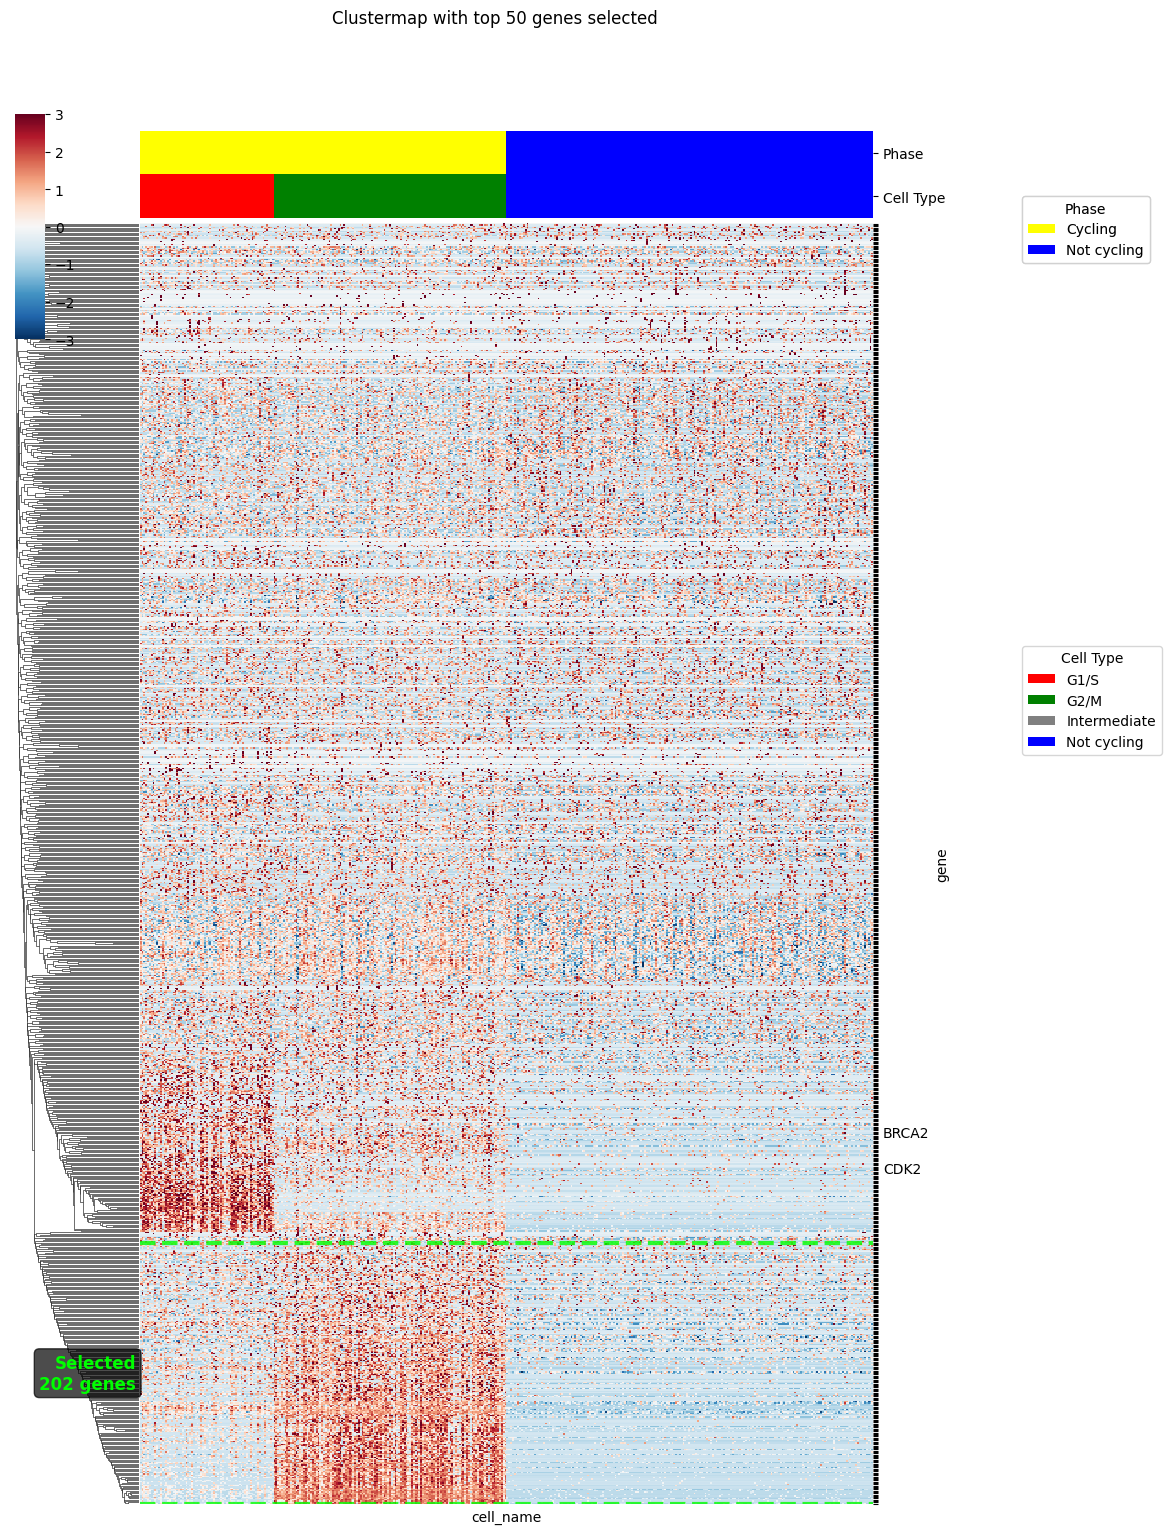


Selected 202 genes:
['ANAPC11', 'ANLN', 'ANP32E', 'ARHGEF39', 'ARL6IP1', 'ASPM', 'AURKA', 'AURKB', 'BANF1', 'BIRC5', 'BORA', 'BRD8', 'BTG3', 'BUB1', 'BUB1B', 'BUB3', 'CALM1', 'CALM2', 'CALM3', 'CCNA2', 'CCNB1', 'CCNB2', 'CCNF', 'CCNG2', 'CCNH', 'CCSAP', 'CDC20', 'CDC25B', 'CDC25C', 'CDC27', 'CDCA2', 'CDCA3', 'CDCA8', 'CDK1', 'CDK5RAP2', 'CDKN1B', 'CDKN2C', 'CDKN2D', 'CDKN3', 'CENPA', 'CENPE', 'CENPF', 'CENPJ', 'CENPK', 'CENPL', 'CENPM', 'CENPN', 'CENPO', 'CENPT', 'CENPW', 'CEP135', 'CEP152', 'CEP55', 'CEP70', 'CEP72', 'CEP97', 'CHEK2', 'CIT', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CNTRL', 'DBF4', 'DBF4B', 'DCTN3', 'DEPDC1', 'DEPDC1B', 'DLGAP5', 'DTYMK', 'DYNLL1', 'ECT2', 'EME1', 'ESPL1', 'FAM110A', 'FAM64A', 'FAM83D', 'FANCD2', 'FANCI', 'FBXO43', 'FOXM1', 'FZR1', 'G2E3', 'GEN1', 'GPSM2', 'GTSE1', 'H2AFZ', 'HJURP', 'HMGB2', 'HMGB3', 'HMGN2', 'HMMR', 'HN1', 'INCENP', 'IQGAP3', 'JADE1', 'KATNA1', 'KIF11', 'KIF14', 'KIF15', 'KIF18A', 'KIF18B', 'KIF20A', 'KIF20B', 'KIF22', 'KIF23', 

In [59]:
result = plot_clustermap_ordered_annotations(
    adata_cycling_subsampled_all_pos, 
    title="Clustermap with top 50 genes selected",
    use_zscore=True,
    select_range=(790, len(adata_cycling_subsampled_all_pos.var_names)),  # Select first 50 genes
    show_genes=["BRCA2", "CDK2"]
)
plt.show()

print(f"\nSelected {len(result['selected_genes'])} genes:")
print(sorted(result['selected_genes']))

In [60]:
# Add to df
positive_genes_df["p_by_visual"] = [g in result['selected_genes'] for g in positive_genes_df.gene.to_list()]
positive_genes_df

gene  geneset_count  is_guaranteed  geneset_count_all     label  \
2      H2AFZ             98           True               1755  positive   
6     MLF1IP             98           True               1755  positive   
1     FAM64A             98           True               1755  positive   
0       CDK1             98           True                894  positive   
4        HN1             98           True               1755  positive   
...      ...            ...            ...                ...       ...   
7278  ZNF782              1          False                 41  ambigous   
7277  ZNF771              1          False                 85  ambigous   
7276  ZNF768              1          False                 97  ambigous   
7275  ZNF766              1          False                 37  ambigous   
7274  ZNF764              1          False                100  ambigous   

      geneset_percent  p_by_visual  
2           33.676976         True  
6           33.676976        False  
1           33.676976         True  
0           33.676976         True  
4           33.676976         True  
...               ...          ...  
7278         0.343643        False  
7277         0.343643        False  
7276         0.343643        False  
7275         0.343643        False  
7274         0.343643        False  

[7294 rows x 7 columns]

### DEG Cyclcing Vs Noncycling

{'params': {'groupby': 'phase', 'reference': 'rest', 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('H2AFZ',), ('HMGB2',), ('KIAA0101',), ('UBE2T',), ('UBE2C',),
           ('STMN1',), ('CENPK',), ('CKS1B',), ('SMC2',), ('DTYMK',),
           ('CKS2',), ('HMGN2',), ('CENPF',), ('SMC4',), ('CENPU',),
           ('MAD2L1',), ('NUSAP1',), ('FAM64A',), ('CDKN3',), ('PTTG1',),
           ('PRC1',), ('TMPO',), ('BIRC5',), ('TPX2',), ('ZWINT',),
           ('CENPW',), ('UBE2S',), ('KIF22',), ('TYMS',), ('CKAP2',),
           ('PBK',), ('AURKA',), ('LMNB1',), ('KPNA2',), ('TUBA1B',),
           ('CENPH',), ('ASF1B',), ('RAN',), ('MYBL2',), ('CCNB1',),
           ('CENPN',), ('TOP2A',), ('MKI67',), ('NUF2',), ('CCNA2',),
           ('TUBB4B',), ('CENPM',), ('RANBP1',), ('ASPM',), ('KIFC1',),
           ('GTSE1',), ('HMGB3',), ('MIS18BP1',), ('TACC3',), ('ORC6',),
           ('CDKN2C',), ('DBF4',), ('CDK1',), ('CKAP2L',), ('DEPDC

names     scores  logfoldchanges         pvals     pvals_adj
0       H2AFZ  17.133694        2.780901  8.320097e-66  8.253536e-63
1       HMGB2  16.171009        4.204329  8.076364e-59  4.005877e-56
2    KIAA0101  16.048187        5.575857  5.885779e-58  1.946231e-55
3       UBE2T  15.766215        5.736936  5.313996e-56  1.317871e-53
4       UBE2C  15.360557        5.139855  3.009802e-53  5.971448e-51
..        ...        ...             ...           ...           ...
987     LSM10  -3.416965       -0.331229  6.332346e-04  1.655704e-03
988    ZNHIT1  -4.118003       -0.343559  3.821703e-05  1.148827e-04
989     SIRT2  -4.130544       -0.580641  3.619053e-05  1.091216e-04
990    RPS27A  -5.611763       -0.249302  2.002762e-08  7.791137e-08
991    CHMP2A  -6.217657       -0.542243  5.046351e-10  2.244834e-09

[477 rows x 5 columns]

/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:138: UserWarning: You’re trying to run this on 992 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  _choose_representation(adata, use_rep=use_rep, n_pcs=n_pcs)


categories: Cycling, Not cycling
var_group_labels: Cycling


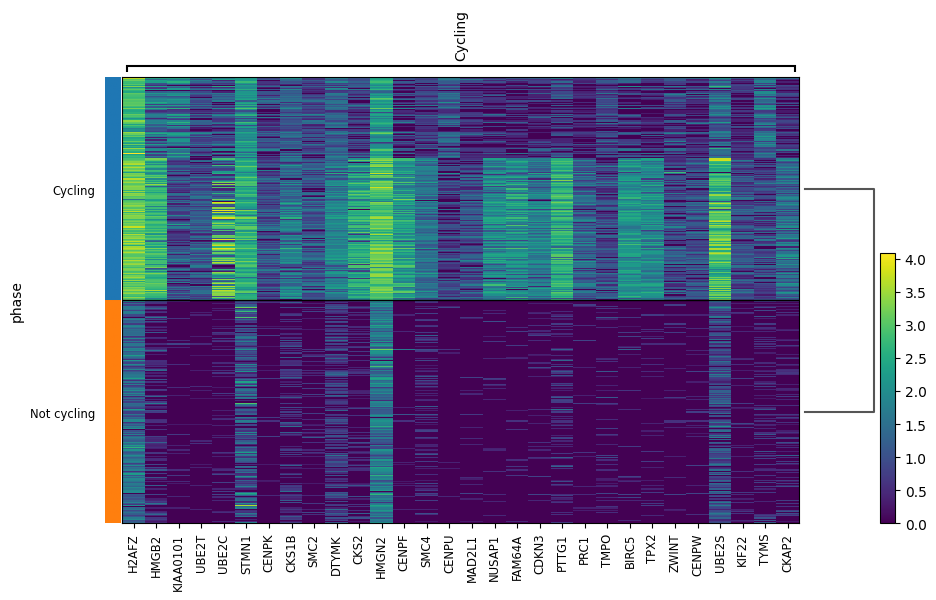

In [61]:
# Test all genes at once
sc.tl.rank_genes_groups( # ATTENTION; needs log norm data
    adata_cycling_subsampled_all_pos, 
    groupby='phase',
    groups=["Cycling"], # DEG in cyclin Vs non cycling
    method='wilcoxon',  # one-vs-rest comparisons
                        # so a gene will be tested n choose k times (in or case 3)
    key_added='phase_de',
    use_raw=False
)

print(adata_cycling_subsampled_all_pos.uns["phase_de"])

# Extract results --> covert to df
# 1. Significant in at least one phase
# 2. Have large fold change
results = sc.get.rank_genes_groups_df(adata_cycling_subsampled_all_pos, group=None, key='phase_de')

# Filter
wilcoxon_positive_genes_df = results[
    results['names'].isin(adata_cycling_subsampled_all_pos.var_names) &
    (results['pvals_adj'] <= 0.05) &
    (results['logfoldchanges'].abs() >= 0.2)
]

display(wilcoxon_positive_genes_df)

sc.pl.rank_genes_groups_heatmap(
    adata_cycling_subsampled_all_pos,
    groups=["Cycling"],
    key="phase_de",
    n_genes=30, # negative fro downregulated genes
    show_gene_labels=True,
)
# Cols are the top genes for each group (e.g., the top 10 markers for Cluster 1, followed by the top 10 for Cluster 2, etc.)
# Row aew cells of that group
#Color Intensity typically represents the ean expression (or Z-score) of the gene

In [62]:
# Add to df
positive_genes_df["p_by_wilcoxon"] = [g in wilcoxon_positive_genes_df.names.to_list() for g in positive_genes_df.gene.to_list()]
positive_genes_df

gene  geneset_count  is_guaranteed  geneset_count_all     label  \
2      H2AFZ             98           True               1755  positive   
6     MLF1IP             98           True               1755  positive   
1     FAM64A             98           True               1755  positive   
0       CDK1             98           True                894  positive   
4        HN1             98           True               1755  positive   
...      ...            ...            ...                ...       ...   
7278  ZNF782              1          False                 41  ambigous   
7277  ZNF771              1          False                 85  ambigous   
7276  ZNF768              1          False                 97  ambigous   
7275  ZNF766              1          False                 37  ambigous   
7274  ZNF764              1          False                100  ambigous   

      geneset_percent  p_by_visual  p_by_wilcoxon  
2           33.676976         True           True  
6           33.676976        False          False  
1           33.676976         True           True  
0           33.676976         True           True  
4           33.676976         True           True  
...               ...          ...            ...  
7278         0.343643        False          False  
7277         0.343643        False          False  
7276         0.343643        False          False  
7275         0.343643        False          False  
7274         0.343643        False          False  

[7294 rows x 8 columns]

gene  geneset_count  is_guaranteed  geneset_count_all     label  \
0      H2AFZ             98           True               1755  positive   
1     MLF1IP             98           True               1755  positive   
2     FAM64A             98           True               1755  positive   
3       CDK1             98           True                894  positive   
4        HN1             98           True               1755  positive   
...      ...            ...            ...                ...       ...   
7289  ZNF782              1          False                 41  ambigous   
7290  ZNF771              1          False                 85  ambigous   
7291  ZNF768              1          False                 97  ambigous   
7292  ZNF766              1          False                 37  ambigous   
7293  ZNF764              1          False                100  ambigous   

      geneset_percent  p_by_visual  p_by_wilcoxon   names     scores  \
0           33.676976         True           True   H2AFZ  17.133694   
1           33.676976        False          False     NaN        NaN   
2           33.676976         True           True  FAM64A  14.377546   
3           33.676976         True           True    CDK1  11.899480   
4           33.676976         True           True     HN1   9.281724   
...               ...          ...            ...     ...        ...   
7289         0.343643        False          False     NaN        NaN   
7290         0.343643        False          False     NaN        NaN   
7291         0.343643        False          False     NaN        NaN   
7292         0.343643        False          False     NaN        NaN   
7293         0.343643        False          False     NaN        NaN   

      logfoldchanges         pvals     pvals_adj  log_prev_ratio  
0           2.780901  8.320097e-66  8.253536e-63       -4.162545  
1                NaN           NaN           NaN       -4.162545  
2           6.379550  7.158764e-47  3.945274e-45       -4.162545  
3           4.681600  1.190877e-32  2.036810e-31       -3.189421  
4           1.206151  1.667586e-20  1.207479e-19       -4.162545  
...              ...           ...           ...             ...  
7289             NaN           NaN           NaN       -5.357552  
7290             NaN           NaN           NaN       -6.409391  
7291             NaN           NaN           NaN       -6.599913  
7292             NaN           NaN           NaN       -5.209453  
7293             NaN           NaN           NaN       -6.643856  

[7294 rows x 14 columns]

Text(0.5, 0, 'log(prevalence_cc_genesets / prevalence_all_genestes)')

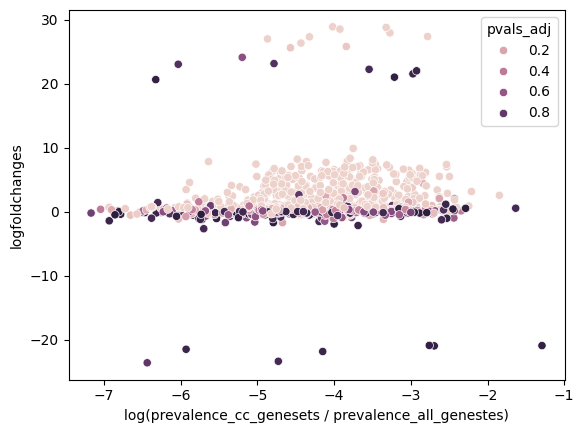

In [63]:
# *) potted log fold
logFC_df = pd.merge(positive_genes_df, results, left_on="gene", right_on="names", how="left")
logFC_df["log_prev_ratio"] = np.log2(logFC_df["geneset_count"] / logFC_df["geneset_count_all"])
display(logFC_df)

sns.scatterplot(
    data=logFC_df,
    x="log_prev_ratio",
    y="logfoldchanges",
    hue="pvals_adj",
)
plt.xlabel("log(prevalence_cc_genesets / prevalence_all_genestes)")

# Final decision

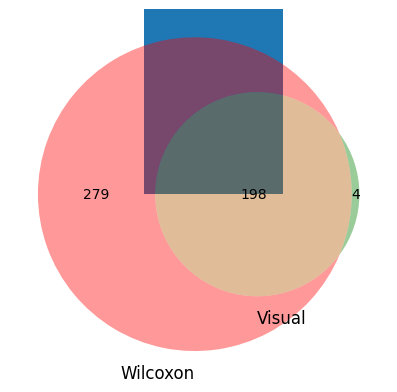

<Axes: xlabel='n_positive'>

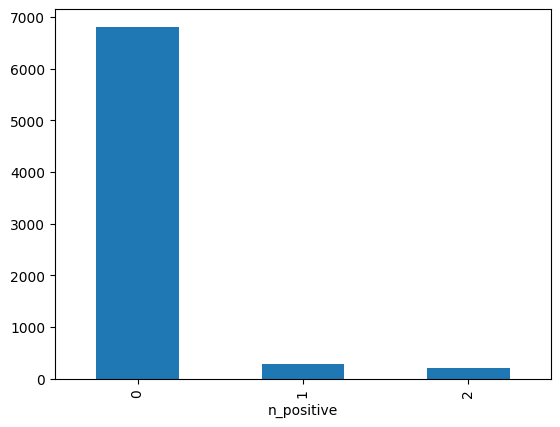

In [64]:
# add if it was èsotve before
positive_genes_df["p_by_broad"] = [g in positive_genes_df[positive_genes_df.label == "positive"].gene.to_list() for g in positive_genes_df.gene.to_list()]

# count
positive_genes_df["n_positive"] = positive_genes_df.apply(
    lambda x: x[["p_by_wilcoxon", "p_by_visual"]].sum(), #p_by_broad
    axis=1
)

# sort
positive_genes_df = positive_genes_df.sort_values(by="n_positive", ascending=False)

positive_genes_df.n_positive.value_counts().sort_index().plot(kind="bar")

from matplotlib_venn import venn2
venn2(
    subsets=(
        set(positive_genes_df.loc[positive_genes_df.p_by_wilcoxon, "gene"]),
        set(positive_genes_df.loc[positive_genes_df.p_by_visual, "gene"]),
        #set(positive_genes_df.loc[positive_genes_df.p_by_broad, "gene"]),
    ),
    set_labels=("Wilcoxon", "Visual")#, "Broad")
)
plt.show()

positive_genes_df.n_positive.value_counts().sort_index().plot(kind="bar")


In [65]:
# asing label
THR=1
# teh False becoms anbiguos genes
positive_genes_df["definitive_positive"] = [True if g in positive_genes_df[positive_genes_df["n_positive"] >= THR].gene.to_list() else False for g in positive_genes_df.gene]

#################
# TEST
# true psotive only by vsual, all rest will be ambigus thsu removed form datasets
positive_genes_df["definitive_positive"] = positive_genes_df["p_by_visual"]

################

# see inly rwl ptiise
definitive_df = positive_genes_df[positive_genes_df["definitive_positive"] == True].sort_values(by="gene")
display(definitive_df)

print(definitive_df.gene.to_list())

positive_genes_df.to_csv(config["data_paths"]["final_positive_genes"], index=False)


gene  geneset_count  is_guaranteed  geneset_count_all     label  \
74    ANAPC11             39          False                202  positive   
134      ANLN             30           True                414  positive   
800    ANP32E             11           True                331  positive   
967  ARHGEF39              9          False                106  positive   
968   ARL6IP1              9           True                314  positive   
..        ...            ...            ...                ...       ...   
528     UBE2T             16           True                462  positive   
798     WDR62             12          False                336  positive   
486      XPO1             17          False                479  positive   
960     YWHAH             10          False                404  positive   
34      ZWINT             48           True                398  positive   

     geneset_percent  p_by_visual  p_by_wilcoxon  p_by_broad  n_positive  \
74         13.402062         True           True        True           2   
134        10.309278         True           True        True           2   
800         3.780069         True           True        True           2   
967         3.092784         True           True        True           2   
968         3.092784         True           True        True           2   
..               ...          ...            ...         ...         ...   
528         5.498282         True           True        True           2   
798         4.123711         True           True        True           2   
486         5.841924         True           True        True           2   
960         3.436426         True           True        True           2   
34         16.494845         True           True        True           2   

     definitive_positive  
74                  True  
134                 True  
800                 True  
967                 True  
968                 True  
..                   ...  
528                 True  
798                 True  
486                 True  
960                 True  
34                  True  

[202 rows x 11 columns]

['ANAPC11', 'ANLN', 'ANP32E', 'ARHGEF39', 'ARL6IP1', 'ASPM', 'AURKA', 'AURKB', 'BANF1', 'BIRC5', 'BORA', 'BRD8', 'BTG3', 'BUB1', 'BUB1B', 'BUB3', 'CALM1', 'CALM2', 'CALM3', 'CCNA2', 'CCNB1', 'CCNB2', 'CCNF', 'CCNG2', 'CCNH', 'CCSAP', 'CDC20', 'CDC25B', 'CDC25C', 'CDC27', 'CDCA2', 'CDCA3', 'CDCA8', 'CDK1', 'CDK5RAP2', 'CDKN1B', 'CDKN2C', 'CDKN2D', 'CDKN3', 'CENPA', 'CENPE', 'CENPF', 'CENPJ', 'CENPK', 'CENPL', 'CENPM', 'CENPN', 'CENPO', 'CENPT', 'CENPW', 'CEP135', 'CEP152', 'CEP55', 'CEP70', 'CEP72', 'CEP97', 'CHEK2', 'CIT', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CNTRL', 'DBF4', 'DBF4B', 'DCTN3', 'DEPDC1', 'DEPDC1B', 'DLGAP5', 'DTYMK', 'DYNLL1', 'ECT2', 'EME1', 'ESPL1', 'FAM110A', 'FAM64A', 'FAM83D', 'FANCD2', 'FANCI', 'FBXO43', 'FOXM1', 'FZR1', 'G2E3', 'GEN1', 'GPSM2', 'GTSE1', 'H2AFZ', 'HJURP', 'HMGB2', 'HMGB3', 'HMGN2', 'HMMR', 'HN1', 'INCENP', 'IQGAP3', 'JADE1', 'KATNA1', 'KIF11', 'KIF14', 'KIF15', 'KIF18A', 'KIF18B', 'KIF20A', 'KIF20B', 'KIF22', 'KIF23', 'KIF2C', 'KIF4A', 'KI

In [66]:
stop

NameError: name 'stop' is not defined

# ------------------------------------------------------------------------------------------------------------

# Select only cycling cells

Use precomputed labels:
- only cycling
- only malignant
    - why? dont want to have cell type influence the analysis

# 1. By Std

Rationale: a gene is cycling in CC if std across cell phases is high

In [ ]:
# # Add phase information
# df_sorted["cell_cycle_phase"] = adata_cc.obs["cell_cycle_phase"].values

# # Compute average expression per phase
# phase_means = df_sorted.groupby("cell_cycle_phase", observed=False).mean() # Calculate the mean of ALL OTHER NUMERIC COLUMNS
# print("Phase means shape:", phase_means.shape)  # Should be (3 phases, n_genes)
# print("Phases:", phase_means.index.tolist())

# # clauclte std acorss the precimputed means
# phase_means.loc["std_across_phases"] = phase_means.std(axis=0)
# print("Gene std shape:", phase_means.loc["std_across_phases"].shape)  # (n_genes,)

# # Select genes with enough variance
# threshold = phase_means.loc["std_across_phases"].quantile(0.25)  # e.g., 2nd percentile

# # Genes with high or low variance
# variable_genes = phase_means.columns[phase_means.loc["std_across_phases"] > threshold]
# constant_genes = phase_means.columns[phase_means.loc["std_across_phases"] <= threshold]

# print("Number of variable genes:", len(variable_genes))

# plt.figure(figsize=(12, 4))

# # Histogram
# plt.subplot(1, 2, 1)
# phase_means.loc["std_across_phases"].plot(kind="hist", bins=100, color='skyblue', edgecolor='black')
# plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
# plt.title("Distribution of gene std across phases")
# plt.xlabel("Std across phases")
# plt.ylabel("Number of genes")
# plt.legend()

# # Sorted values
# plt.subplot(1, 2, 2)
# phase_means.loc["std_across_phases"].sort_values().plot(color='skyblue')
# plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
# plt.title("Sorted gene std across phases")
# plt.xlabel("Genes (sorted)")
# plt.ylabel("Std across phases")
# plt.legend()

# plt.tight_layout()
# plt.show()

In [ ]:
# # Full phase_means clustermap
# sns.clustermap(
#     phase_means.iloc[:-1, :],  # exclude std row if needed
#     figsize=(12, 4),
#     cmap="viridis",
#     col_cluster=True,  # cluster genes
#     row_cluster=False, # do not cluster phases
#     method="average",
#     metric="correlation",
#     xticklabels=False,
#     yticklabels=True,
#     standard_scale=1,
# )
# plt.suptitle("Mean expression per gene across cell phases", y=1.05)

# # Variable genes only
# sns.clustermap(
#     phase_means.iloc[:-1, :][variable_genes],  # exclude std row if needed
#     figsize=(12, 4),
#     cmap="viridis",
#     col_cluster=True,  # cluster genes
#     row_cluster=False, # do not cluster phases
#     method="average",
#     metric="correlation",
#     xticklabels=False,
#     yticklabels=True,
#     standard_scale=1,
# )
# plt.suptitle("Clustermap of variable genes", y=1.05)


In [ ]:
# # add results to df
# positive_genes_df["p_by_std"] = [g in variable_genes for g in positive_genes_df.gene.to_list()]

# By Kruskal test


In [ ]:
# import numpy as np
# from scipy.stats import kruskal
# from statsmodels.stats.multitest import multipletests

# # Test each gene for differential expression across phases
# results = []

# for gene in broad_positive_gene_list_in_adata:
#     # Get expression values per phase
#     expr_by_phase = {} #A dictionary with N(one per phase) lists (each elemnt is a cell) of expression values 
#     for phase in adata_cc.obs['cell_cycle_phase'].unique():
#         cells = adata_cc.obs['cell_cycle_phase'] == phase #extract all cells in that phase
#         expr_by_phase[phase] = adata_cc[cells, gene].X.toarray().flatten() #Get expression values for the gene across those cells
    
#     # Check if gene has any variance at all
#     all_values = np.concatenate(list(expr_by_phase.values()))
#     if np.std(all_values) < 1e-10:  # Skip genes with no variance
#         continue
    
#     # Check if there's variance within at least 2 groups
#     variances = [np.std(v) for v in expr_by_phase.values()]
#     if sum(v > 1e-10 for v in variances) < 2:  # Need variance in at least 2 phases
#         continue
    
#     try:
#         # Kruskal-Wallis test (non-parametric ANOVA) 
#         # Treats each cell independently (ignores biological replicates) --> WRING !!!
#         stat, pval = kruskal(*expr_by_phase.values())
        
#         # Calculate effect size (variance across phase means)
#         #p-value tells you IF there's a difference
#         #Effect size tells you HOW BIG the difference is
#         phase_means = [np.mean(v) for v in expr_by_phase.values()]
#         effect_size = np.std(phase_means)
        
#         results.append({
#             'gene': gene,
#             'pvalue': pval,
#             'effect_size': effect_size,
#             'mean_expr': np.mean(all_values)
#         })
#     except ValueError:
#         # Skip genes that still cause issues
#         continue

# results_df = pd.DataFrame(results)

# # multi teset conrrection
# results_df['pvalue_adj'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

# # Keep genes with significant variation AND large effect
# cc_genes = results_df[
#     (results_df['pvalue_adj'] < 0.05) & 
#     (results_df['effect_size'] > results_df['effect_size'].quantile(0.2))  
# ]['gene'].tolist()

# print(f"Found {len(cc_genes)} cell cycle genes")
# display(results_df.sort_values('effect_size', ascending=False))

# sorted(cc_genes)

# positive_genes_df["p_by_kruskal"] = [g in cc_genes for g in positive_genes_df.gene.to_list()]


# By Wilcoxon Test

Not optimal test for scrna (nned pseudobulk and desseq2 or Limma or EdgeR)

In [ ]:
# # Test all genes at once
# sc.tl.rank_genes_groups( # ATTENTION; needs log norm data
#     adata_cc, 
#     groupby='cell_cycle_phase',
#     method='wilcoxon',  # one-vs-rest comparisons
#                         # so a gene will be tested n choose k times (in or case 3)
#     key_added='phase_de',
#     use_raw=False
# )

# print(adata_cc.uns["phase_de"])

# # Extract results --> covert to df
# # 1. Significant in at least one phase
# # 2. Have large fold change
# results = sc.get.rank_genes_groups_df(adata_cc, group=None, key='phase_de')

# # Filter
# wilcoxon_positive_genes_df = results[
#     results['names'].isin(broad_positive_gene_list_in_adata) &
#     (results['pvals_adj'] <= 0.05) &
#     (results['logfoldchanges'].abs() >= 0.2)
# ]

# display(wilcoxon_positive_genes_df)

In [ ]:
# sc.pl.rank_genes_groups_heatmap(
#     adata_cc,
#     #groups=,
#     key="phase_de",
#     n_genes=10, # negative fro downregulated genes
#     show_gene_labels=True
# )
# # Cols are the top genes for each group (e.g., the top 10 markers for Cluster 1, followed by the top 10 for Cluster 2, etc.)
# # Row aew cells of that group
# #Color Intensity typically represents the ean expression (or Z-score) of the gene

In [ ]:
# # add
# positive_genes_df["p_by_wilcoxon"] = [g in wilcoxon_positive_genes_df.names.to_list() for g in positive_genes_df.gene.to_list()]


In [ ]:
# # Create mapping: cell-phase --> color

# # Check what phases you actually have
# print("Unique phases:", phases_sorted.unique())
# print("Phase counts:", phases_sorted.value_counts())

# # Create color mapping - make sure these match your actual phase names
# phase_color_map = {
#     'G1/S': '#1f77b4',
#     'Intermediate': '#ff7f0e', 
#     'G2/M': '#2ca02c',
# }

# phase_colors = phases_sorted.map(phase_color_map)


# #########

# # get the most iffrtuallye xpressed gens ofr wach group:
# N=20
# genes_list = []
# for i, g in wilcoxon_positive_genes_df.sort_values(by="scores").groupby("group"):
#     print(i)
#     #display(g)
#     genes_list = genes_list + g.names[:N].to_list()

# genes_list


# ########


# # Create the clustermap
# g = sns.clustermap(
#     df_sorted.loc[:, df_sorted.columns.isin(genes_list)],  # cells are row
#     figsize=(10, 14),
#     cmap="viridis",

#     col_cluster=True, #wnat to cluster genes
#     row_cluster=False,

#     method="average", # method to do clustering
#     metric="correlation", # metric to aggregate in hierarhcical clustering

#     row_colors=phase_colors,
#     xticklabels=False,
#     yticklabels=True,
#     colors_ratio=0.05,  
#     dendrogram_ratio=0.1,

#     standard_scale=1, #for each row(0) or column, subtract the minimum and divide each by its maximum.

# )

# # Add legend
# from matplotlib.patches import Patch
# legend_elements = [Patch(facecolor=color, label=phase) 
#                    for phase, color in phase_color_map.items()]
# g.ax_heatmap.legend(handles=legend_elements, loc='upper left', 
#                     bbox_to_anchor=(1.02, 1), frameon=True)

# Final Decision

In [ ]:
# # add if it was èsotve before
# positive_genes_df["p_by_broad"] = [g in positive_genes_df[positive_genes_df.label == "positive"].gene.to_list() for g in positive_genes_df.gene.to_list()]

# # count
# positive_genes_df["n_positive"] = positive_genes_df.apply(
#     lambda x: x[["p_by_broad", "p_by_std", "p_by_wilcoxon"]].sum(),
#     axis=1
# )

# # sort
# positive_genes_df = positive_genes_df.sort_values(by="n_positive", ascending=False)

# positive_genes_df.n_positive.value_counts().sort_index().plot(kind="bar")

In [ ]:
# # asing label
# THR=3
# positive_genes_df["definitive_positive"] = [True if g in positive_genes_df[positive_genes_df["n_positive"] >= THR].gene.to_list() else False for g in positive_genes_df.gene]

# # see inly rwl ptiise
# definitive_df = positive_genes_df[positive_genes_df["definitive_positive"] == True].sort_values(by="gene")
# display(definitive_df)

# print(definitive_df.gene.to_list())

# Save

In [ ]:
positive_genes_df.to_csv(config["data_paths"]["final_positive_genes"], index=False)

# Caveats

1) missing genes in scrna daatset ase not studied
2) removed geens with  expresson
3) some genes are expressed in mutple pahses (ex CDK1)
4) cell type expression differces are not accounted
5) using std, we have to average bvefpre. bit mean is not a good metric for spiky expression
6) stat tets not ptimal for scrna data

 ---
# Optional
 ---

# Are there Enriched genesets?

After getting definitive positive genes, perform hypergeometric test.

Universe is ALL genesets (not jsut the one found previusly) with AT LEAST 10 genes.

In [ ]:
# plit psoive genes
positive_genes = set(positive_genes_df[positive_genes_df.definitive_positive == True].gene)
print("Number positive genes", len(positive_genes))

# Read MSigDB genesets
df_genesets = dataf.load_json_folder_to_df(config["data_paths"]["MSigDB_all_data"])
df_genesets = df_genesets.drop_duplicates(subset=['set_name'], keep='first')
# rename
df_genesets["gene_list"] = df_genesets["geneSymbols"]
# Recalculate n_genes
df_genesets["n_genes"] = df_genesets["gene_list"].apply(len)
#subset
df_genesets = df_genesets[["set_name", "gene_list", "n_genes"]]

#  extartc only psotive geens per geneset
df_genesets["genes_positive"] = df_genesets.apply(
    lambda row: (
        [g for g in row["gene_list"] if g in positive_genes]
    ),
    axis=1
)
df_genesets["n_genes_positive"] = df_genesets["genes_positive"].apply(len)
df_genesets.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(df_genesets.head(5))

############

# read psortive genesets found before
df_genesets_positive = pd.read_csv(config["data_paths"]["positive_genesets"])
df_genesets_positive["gene_list"] = df_genesets_positive["geneSymbols"].apply(ast.literal_eval)
df_genesets_positive = df_genesets_positive[["set_name", "gene_list", "n_genes"]]
df_genesets_positive["genes_positive"] = df_genesets_positive.apply(
lambda row: (
        [g for g in row["gene_list"] if g in positive_genes]
    ),
    axis=1
)
df_genesets_positive["n_genes_positive"] = df_genesets_positive["genes_positive"].apply(len)
df_genesets_positive.sort_values(by="n_genes_positive", ascending=False, inplace=True)
# ratio of psotve genes
df_genesets_positive["n_genes_ratio"] = df_genesets_positive["n_genes_positive"] / df_genesets_positive["n_genes"]

display(df_genesets_positive.head(5))


Number positive genes 392


set_name  \
19134                            GOBP_CELL_CYCLE   
20256                    GOBP_CELL_CYCLE_PROCESS   
33730                      FISCHER_DREAM_TARGETS   
57722  HE_LIM_SUN_FETAL_LUNG_C5_LARGE_PRE_B_CELL   
18135                    GOBP_MITOTIC_CELL_CYCLE   

                                               gene_list  n_genes  \
19134  [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...     1705   
20256  [AAAS, ABCB1, ABRAXAS1, ABRAXAS2, ACTB, ACTL6A...     1348   
33730  [AAAS, AARS1, ABCB10, ABCE1, ABHD10, ABHD2, AC...      969   
57722  [AAAS, AAGAB, AAMDC, AARS1, ABCD3, ABHD12, ABH...     1363   
18135  [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...      931   

                                          genes_positive  n_genes_positive  
19134  [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               305  
20256  [ANAPC11, ANAPC15, ANAPC5, ANKLE2, ANKRD17, AR...               287  
33730  [ANKRD17, ANP32E, ARHGEF39, ARL6IP1, ASPM, ATA...               259  
57722  [ANAPC15, ANP32E, ARHGEF39, ARL6IP1, ASPM, ATA...               244  
18135  [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               241

set_name  \
49                            GOBP_CELL_CYCLE   
66                    GOBP_CELL_CYCLE_PROCESS   
44                    GOBP_MITOTIC_CELL_CYCLE   
290   HE_LIM_SUN_FETAL_LUNG_C4_CYCLING_T_CELL   
287  HE_LIM_SUN_FETAL_LUNG_C2_CYCLING_DC_CELL   

                                             gene_list  n_genes  \
49   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...     1705   
66   [AAAS, ABCB1, ABRAXAS1, ABRAXAS2, ACTB, ACTL6A...     1348   
44   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...      931   
290  [A1BG, AAAS, AARS1, ABHD12, ABI2, ACAD9, ACAT2...      939   
287  [AAAS, AARS1, AARS2, AASDH, ABCB7, ABCB8, ACAA...     1423   

                                        genes_positive  n_genes_positive  \
49   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               305   
66   [ANAPC11, ANAPC15, ANAPC5, ANKLE2, ANKRD17, AR...               287   
44   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               241   
290  [ANAPC15, ARHGEF39, ARL6IP1, ASPM, ATAD2, ATAD...               231   
287  [ANAPC15, ARHGEF39, ASPM, ATAD2, ATAD5, AURKA,...               227   

     n_genes_ratio  
49        0.178886  
66        0.212908  
44        0.258861  
290       0.246006  
287       0.159522

/tmp/ipykernel_12072/1603268317.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


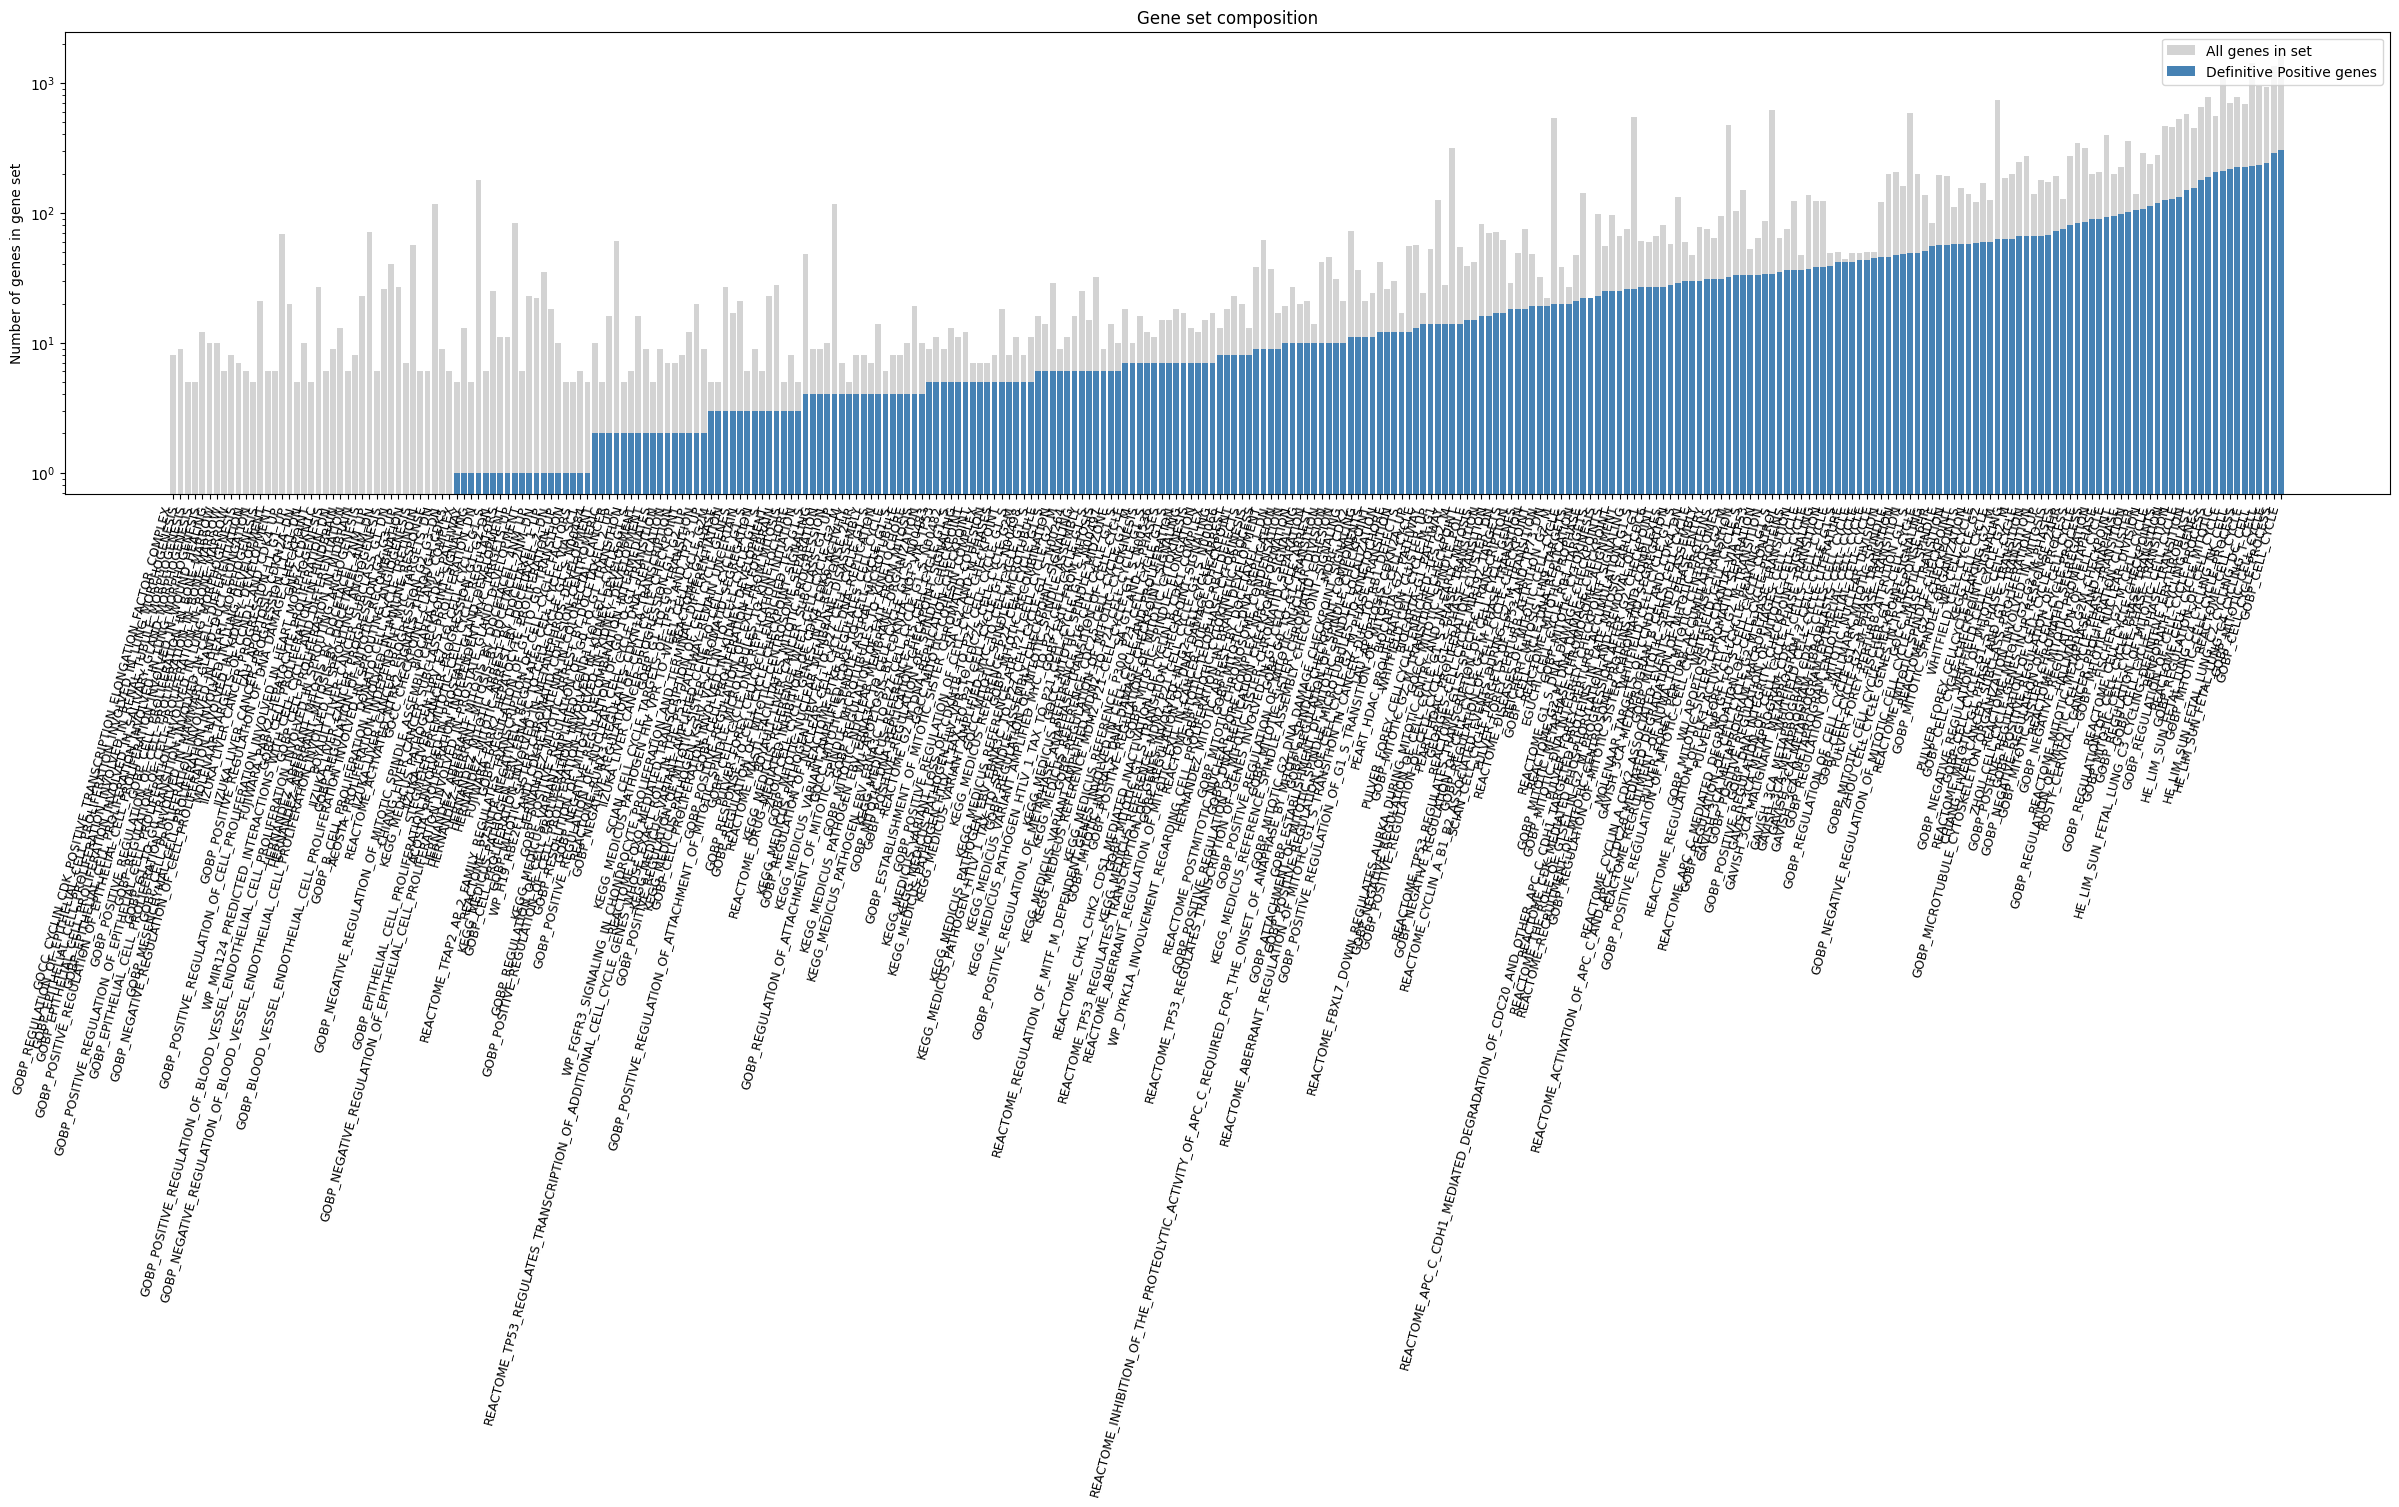

In [ ]:
# HOW MANY DEFINITIVE POSITIVE GENES IN ORIGINAL POSITIVE GENESTES

# Sort by significance (optional)
df_plot = df_genesets_positive.copy().sort_values("n_genes_positive")

# Create figure and axis
fig, ax = plt.subplots(figsize=(30, 6))

# Base layer: total genes
ax.bar(
    df_plot["set_name"],
    df_plot["n_genes"],
    color="lightgray",
    label="All genes in set",
)

# Overlay: positive genes
ax.bar(
    df_plot["set_name"],
    df_plot["n_genes_positive"],
    color="steelblue",
    label="Definitive Positive genes"
)

# Add labels and aesthetics
ax.set_xticks(range(len(df_plot["set_name"])))
ax.set_xticklabels(df_plot["set_name"], rotation=75, ha="right", fontsize=9)
ax.set_ylabel("Number of genes in gene set")
ax.set_title("Gene set composition")
ax.legend(loc="upper right")
ax.set_yscale("log")

plt.tight_layout()
plt.show()


In [ ]:
# HYPERGEMOETRIC TEST

# Filter genesets with enough genes
    # ATTENTION
    # CANNOT USE TOO SMALL DRAWING (n) --> test power comes from the changing probabilities over several draws, known as sampling without replacemen
df_genesets_big = df_genesets[df_genesets.n_genes >= 1].copy()

# Define background
total_genes = len(set().union(*df_genesets_big["gene_list"]))
total_positive = len(set().union(*df_genesets_big["genes_positive"]))
print(f"Unique total genes: {total_genes}")
print(f"Unique total positive genes: {total_positive}")

# Run enrichment test
results = df_genesets_big.apply(
    lambda row: pd.Series(
        dataf.per_cluster_hypergeom_test(
            row["n_genes"], 
            row["n_genes_positive"], 
            total_genes, 
            total_positive
        )
    ), 
    axis=1
)
results.columns = ["enrichment_prob", "enrichment_pvalue"]

# Combine results
df_genesets_enriched = pd.concat([df_genesets_big, results], axis=1)
df_genesets_enriched = df_genesets_enriched.sort_values("enrichment_pvalue")

# Multiple testing correction (FDR)
df_genesets_enriched["enrichment_pvalue_adj"] = multipletests(
    df_genesets_enriched["enrichment_pvalue"], 
    method="fdr_bh"
)[1]
df_genesets_enriched["significant"] = df_genesets_enriched["enrichment_pvalue_adj"] < 0.05

# Summary
print(f"\nSignificant enriched gene sets: {df_genesets_enriched['significant'].sum()} / {len(df_genesets_enriched)}")
display(
    df_genesets_enriched[
        ["set_name", "n_genes", "n_genes_positive", 
         "enrichment_prob", "enrichment_pvalue", 
         "enrichment_pvalue_adj", "significant"]
    ].head(10)
)

# only enriched
df_genesets_significant = df_genesets_enriched[df_genesets_enriched['significant'] == True]

Unique total genes: 43351
Unique total positive genes: 388

Significant enriched gene sets: 7994 / 35134


set_name  n_genes  \
39663             FIGAROL_EGFR_TKI_DRUG_TOLERANT_CELL_DN      495   
23424                  GOBP_MEIOSIS_I_CELL_CYCLE_PROCESS      142   
8470   GOCC_TRANSFERASE_COMPLEX_TRANSFERRING_PHOSPHOR...      310   
35041                       REACTOME_CELLULAR_SENESCENCE      197   
3778          GSE34205_HEALTHY_VS_RSV_INF_INFANT_PBMC_DN      200   
49753                                           MORF_DEK      264   
37981              MOLENAAR_TARGETS_OF_CCND1_AND_CDK4_DN       59   
4443                  GSE2128_C57BL6_VS_NOD_THYMOCYTE_UP      199   
5475   GSE16451_CTRL_VS_WEST_EQUINE_ENC_VIRUS_IMMATUR...      200   
38615                                    PID_E2F_PATHWAY       73   

       n_genes_positive  enrichment_prob  enrichment_pvalue  \
39663               198    2.578402e-290                0.0   
23424                30     2.327813e-32                0.0   
8470                 30     5.428911e-22                0.0   
35041                30     7.180237e-28                0.0   
3778                 30     1.143374e-27                0.0   
49753                30     4.950161e-24                0.0   
37981                30     5.331897e-46                0.0   
4443                 30     9.799980e-28                0.0   
5475                 30     1.143374e-27                0.0   
38615                30     2.239099e-42                0.0   

       enrichment_pvalue_adj  significant  
39663                    0.0         True  
23424                    0.0         True  
8470                     0.0         True  
35041                    0.0         True  
3778                     0.0         True  
49753                    0.0         True  
37981                    0.0         True  
4443                     0.0         True  
5475                     0.0         True  
38615                    0.0         True

Original gene sets: 291
Significantly enriched gene sets: 7994
Overlap (shared sets): 230

Original genesets that are enriched:


set_name  \
49                                     GOBP_CELL_CYCLE   
66                             GOBP_CELL_CYCLE_PROCESS   
44                             GOBP_MITOTIC_CELL_CYCLE   
290            HE_LIM_SUN_FETAL_LUNG_C4_CYCLING_T_CELL   
287           HE_LIM_SUN_FETAL_LUNG_C2_CYCLING_DC_CELL   
..                                                 ...   
169       SCIAN_CELL_CYCLE_TARGETS_OF_TP53_AND_TP73_UP   
114  GOBP_CELL_PROLIFERATION_INVOLVED_IN_METANEPHRO...   
21   KEGG_MEDICUS_VARIANT_AMPLIFIED_CCND1_TO_CELL_C...   
112  GOBP_MITOTIC_SISTER_CHROMATID_COHESION_CENTROM...   
125  GOBP_REGULATION_OF_CELL_PROLIFERATION_INVOLVED...   

                                             gene_list  n_genes  \
49   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...     1705   
66   [AAAS, ABCB1, ABRAXAS1, ABRAXAS2, ACTB, ACTL6A...     1348   
44   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...      931   
290  [A1BG, AAAS, AARS1, ABHD12, ABI2, ACAD9, ACAT2...      939   
287  [AAAS, AARS1, AARS2, AASDH, ABCB7, ABCB8, ACAA...     1423   
..                                                 ...      ...   
169  [CDKN1A, GAS2L1, HRAS, JAG2, LTBP2, NEDD9, SEP...        9   
114  [BMP7, EGR1, GPC3, MYC, OSR1, PDGFRB, PTCH1, S...       10   
21                [CCND1, CDK4, E2F1, E2F2, E2F3, RB1]        6   
112                   [BOD1, BUB1, NAA10, NAA50, SGO1]        5   
125  [BMP4, BMP7, CFLAR, EGR1, FLCN, GATA3, IL6R, I...       16   

                                        genes_positive  n_genes_positive  \
49   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               305   
66   [ANAPC11, ANAPC15, ANAPC5, ANKLE2, ANKRD17, AR...               287   
44   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               241   
290  [ANAPC15, ARHGEF39, ARL6IP1, ASPM, ATAD2, ATAD...               231   
287  [ANAPC15, ARHGEF39, ASPM, ATAD2, ATAD5, AURKA,...               227   
..                                                 ...               ...   
169                                     [CDKN1A, TP53]                 2   
114                                      [EGR1, STAT1]                 2   
21                                        [CDK4, E2F1]                 2   
112                                      [BUB1, NAA10]                 2   
125                                      [CFLAR, EGR1]                 2   

     n_genes_ratio  
49        0.178886  
66        0.212908  
44        0.258861  
290       0.246006  
287       0.159522  
..             ...  
169       0.222222  
114       0.200000  
21        0.333333  
112       0.400000  
125       0.125000  

[230 rows x 6 columns]


Original genesets that are NOT enriched:


set_name  \
246      CHIANG_LIVER_CANCER_SUBCLASS_PROLIFERATION_DN   
176                BOYAULT_LIVER_CANCER_SUBCLASS_G1_UP   
255    ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_DN   
231    ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_UP   
165     HERNANDEZ_ABERRANT_MITOSIS_BY_DOCETACEL_2NM_UP   
..                                                 ...   
122  GOBP_NEGATIVE_REGULATION_OF_MITOTIC_SPINDLE_AS...   
26   KEGG_MEDICUS_PATHOGEN_EBV_EBNA3C_TO_CELL_CYCLE...   
2                        GOCC_CHECKPOINT_CLAMP_COMPLEX   
98   GOBP_EPITHELIAL_CELL_PROLIFERATION_INVOLVED_IN...   
97   GOBP_EPITHELIAL_CELL_PROLIFERATION_INVOLVED_IN...   

                                             gene_list  n_genes  \
246  [AADAC, AASS, ABAT, ABCA6, ABCA8, ABCB11, ABCB...      179   
176  [ABCC10, ABHD3, ADAR, ADGRG1, AHNAK, AHSA2P, A...      116   
255  [ACRV1, ACSM3, ADAM8, ADAMTSL4, ADGRE5, ADGRG1...      116   
231  [AATF, BLMH, CCNE1, CD320, CLUH, CRYBG2, CSE1L...       84   
165  [AGT, ARHGDIB, ASNS, BNC2, BTRC, CASP7, CD3D, ...       71   
..                                                 ...      ...   
122              [MAD1L1, MAD2L1BP, PRAP1, SKA1, SKA3]        5   
26                       [E2F1, E2F2, E2F3, RB1, SKP2]        5   
2                    [HUS1, HUS1B, RAD1, RAD9A, RAD9B]        5   
98                   [AREG, ESR1, MED1, TFAP2C, WNT5A]        5   
97                    [FGF10, FGFR2, NKX3-1, SHH, TNF]        5   

                genes_positive  n_genes_positive  n_genes_ratio  
246                     [RHOB]                 1       0.005587  
176  [DNAJC9, LBR, LMNA, RPA1]                 4       0.034483  
255                         []                 0       0.000000  
231                    [CCNE1]                 1       0.011905  
165                         []                 0       0.000000  
..                         ...               ...            ...  
122                     [SKA1]                 1       0.200000  
26                      [E2F1]                 1       0.200000  
2                      [RAD9A]                 1       0.200000  
98                          []                 0       0.000000  
97                          []                 0       0.000000  

[61 rows x 6 columns]

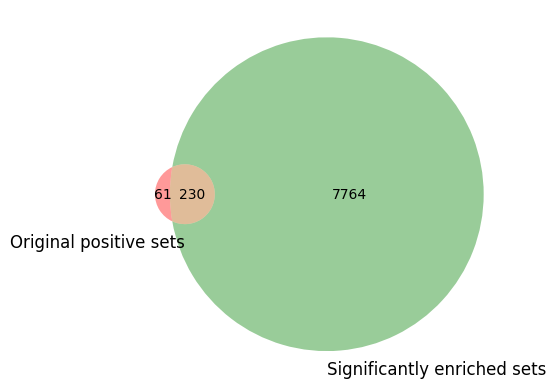

In [ ]:
# PLOT HOW MANY ORTIGNA PSTIVE GENESTES ARE ENRICHED BASED ON DEFINITVE POSTIVE GENS

# Define your sets
original_genesets = set(df_genesets_positive.set_name)
enriched_genesets = set(df_genesets_significant.set_name)
intersection_genesets = original_genesets & enriched_genesets
only_original_genesets = original_genesets - enriched_genesets
only_enriched_genesets = enriched_genesets - original_genesets

#  summary info
print(f"Original gene sets: {len(original_genesets)}")
print(f"Significantly enriched gene sets: {len(enriched_genesets)}")
print(f"Overlap (shared sets): {len(intersection_genesets)}")

print("\nOriginal genesets that are enriched:")
display(df_genesets_positive[df_genesets_positive.set_name.isin(intersection_genesets)])

print("\nOriginal genesets that are NOT enriched:")
display(df_genesets_positive[df_genesets_positive.set_name.isin(only_original_genesets)]
        .sort_values(by="n_genes", ascending=False))

# --- Visualization ---
venn2(
    subsets=(
        len(only_original_genesets),
        len(only_enriched_genesets),
        len(intersection_genesets)
    ),
    set_labels=('Original positive sets', 'Significantly enriched sets'),
)
